<a name="polyp-segmentation:-data-exploration-and-dataset-preperation"></a>
# Polyp Segmentation: Data Exploration and Dataset Preperation

<a name="what-is-polyp-segmentation?"></a>
## What is Polyp Segmentation?
Polyp segmentation is a specific application of semantic segmentation in the field of medical imaging, particularly endoscopy. The task here is to identify and delineate the boundaries of polyps in endoscopic images. Polyps are abnormal growths in the lining of the colon that could be benign but may also turn into cancerous lesions. Therefore, their accurate and prompt identification is crucial for effective diagnosis and treatment.

<a name="about-the-dataset"></a>
## About the Dataset

The Kvasir-SEG dataset is an open-access collection of gastrointestinal polyp images and their corresponding segmentation masks. These masks are manually annotated and verified by experienced gastroenterologists. The dataset aims to facilitate research in the field of polyp segmentation and automatic analysis of colonoscopy videos. It contains 1000 polyp images with resolutions ranging from 332x487 to 1920x1072 pixels.

<a name="import-modules"></a>
## Import Libraries

In [ ]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-e1x9l8wd
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-e1x9l8wd
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 13.9 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.0.2-py3-none-any.whl size=13716 sha256=a7a1970049eb0a857f18cda296d50a9789437f6f82c1fd814eb7fb68dd5d170e
  Stored in directory: /tmp/pip-ephem-wheel-cache-rx97cce2/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras


In [ ]:
!pip install keras_cv_attention_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.2/773.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 831.2 kB/s eta 0:00:00


In [ ]:
from glob import glob
import json
from PIL import Image
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import (Input, Conv2D, MaxPooling2D, concatenate,
Conv2DTranspose, BatchNormalization, Dropout, Activation, MaxPool2D, Concatenate,
Dense, GlobalAveragePooling2D, Lambda, Reshape, Add, Multiply, UpSampling2D,
ZeroPadding2D, LayerNormalization)
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.optimizers import Adam, Nadam, AdamW
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras_cv_attention_models import convnext, efficientnet
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import regularizers
from keras_cv_attention_models import attention_layers
import visualkeras
import keras
import os
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/kvasirseg.zip -d /content/drive/MyDrive/Project-Deep-Learning

Archive:  /content/drive/MyDrive/kvasirseg.zip
   creating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG/
  inflating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG/kavsir_bboxes.json  
   creating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG/images/
  inflating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG/images/ck2bxiswtxuw80838qkisqjwz.jpg  
  inflating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG/images/ck2bxknhjvs1x0794iogrq49k.jpg  
  inflating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG/images/ck2bxlujamu330725szlc2jdu.jpg  
  inflating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG/images/ck2bxpfgxu2mk0748gsh7xelu.jpg  
  inflating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG/images/ck2bxqz3evvg20794iiyv5v2m.jpg  
  inflating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG/images/ck2bxskgxxzfv08386xkqtqdy.jpg  
  inflating: /content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG

## Configure File Accessibility
```
Kvasir-SEG
├── images
│   ├── cju0qkwl35piu0993l0dewei2.jpg
│   ├── cju0qoxqj9q6s0835b43399p4.jpg
│   ├── ...
│   
├── masks
│   ├── cju0qkwl35piu0993l0dewei2.jpg
│   ├── cju0qoxqj9q6s0835b43399p4.jpg
│   ├── ...
│
└── kavsir_bboxes.json
```

Both subfolders "images" and "masks" contain 1000 images respectively.

### Verify file format and quantity

In [ ]:
# Define the path to the "Kvasir-SEG" directory and the "images" and "masks" subdirectories
data_dir = "/content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

# Get a list of filenames in the "images" and "masks" subdirectories
images_files = os.listdir(images_dir)
masks_files = os.listdir(masks_dir)

# Check the file format of each image file in the images folder
images_formats = set()
for file_name in os.listdir(images_dir):
    file_path = os.path.join(images_dir, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        images_formats.add(file_format)

# Check the file format of each image file in the masks folder
masks_formats = set()
for file_name in os.listdir(masks_dir):
    file_path = os.path.join(masks_dir, file_name)
    if os.path.isfile(file_path):
        file_format = file_name.split(".")[-1]
        masks_formats.add(file_format)

# Print the number of images and masks, along with their file formats
print(f"There are {len(images_files)} colonoscopic images with {images_formats} format")
print(f"There are {len(masks_files)} segmentation masked images with {masks_formats} format")

There are 1000 colonoscopic images with {'jpg'} format
There are 1000 segmentation masked images with {'jpg'} format


## Explore Image Data

### Check image basic components

In [ ]:
# Read first image from RGB colonoscopic images
cv2.imread(os.path.join(images_dir,images_files[0]))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

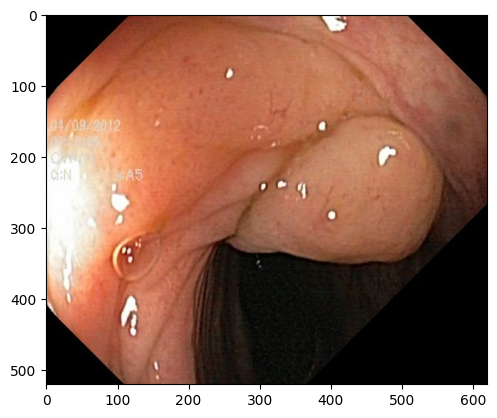

In [ ]:
# Read image (BGR by default)
BGR_img1 = cv2.imread(os.path.join(images_dir,images_files[0]))

# Convert BGR to RGB
RGB_img1 = cv2.cvtColor(BGR_img1, cv2.COLOR_BGR2RGB)

# Display image
plt.imshow(RGB_img1)
plt.show()

In [ ]:
# Check shape of image
RGB_img1.shape

(520, 621, 3)

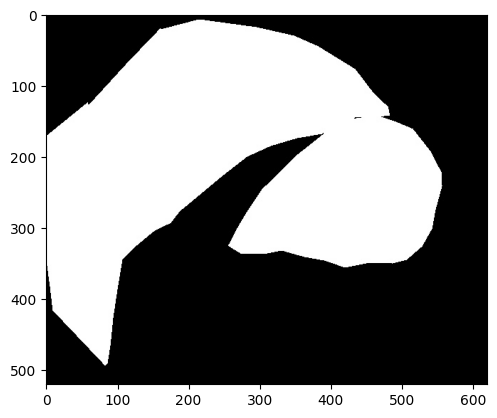

In [ ]:
# Read first image from mask images
mask_img1 = cv2.imread(os.path.join(masks_dir,masks_files[0]))

# Display image
plt.imshow(mask_img1)
plt.show()

In [ ]:
# Check shape of image
mask_img1.shape

(520, 621, 3)

While a grayscale image is typuically known to have 1 channel, here we our image has 3 channels because it is a colored image with the same values for all the three channels (r, g, b) in every pixel. Therefore, visually it looks like a grayscale image. Let's now check the minimum and maximum pixel value for both the RGB and mask image.

In [ ]:
#Find out the min and max values of pixels in the RGB image
print('RGB Image:')
print('Image minimum value: ',RGB_img1.min())
print('Image maximum value: ',RGB_img1.max())

#Find out the min and max values of pixels in the mask image
print('Mask Image:')
print('Image minimum value: ',mask_img1.min())
print('Image maximum value: ',mask_img1.max())

RGB Image:
Image minimum value:  0
Image maximum value:  255
Mask Image:
Image minimum value:  0
Image maximum value:  255


Both the RGB and mask have the same minimum and maximum pixel value. The minimum pixel value in the image is 0 which represents black and the maximum pixel value of 255 represents white. When loading the image, we have a dtype of uint8 (unsigned), so the pixel intensity values range have $2^8$ values or 256 values to work with. Because it is unsigned, it does not have negative values.

Later when it comes to data preprocessing, we will rescale the data by dividing it by the maximum pixel value (255) before applying it to ensure that the data falls within a similar range and has a consistent scale, which can improve the performance and convergence of the model.


### Check image width and height

Extract the widths and heights of all images

In [ ]:
heights = [cv2.imread(os.path.join(images_dir,images_files[idx])).shape[0] for idx in range(len(images_files))]
widths = [cv2.imread(os.path.join(images_dir,images_files[idx])).shape[1] for idx in range(len(images_files))]

Widths and heights distribution

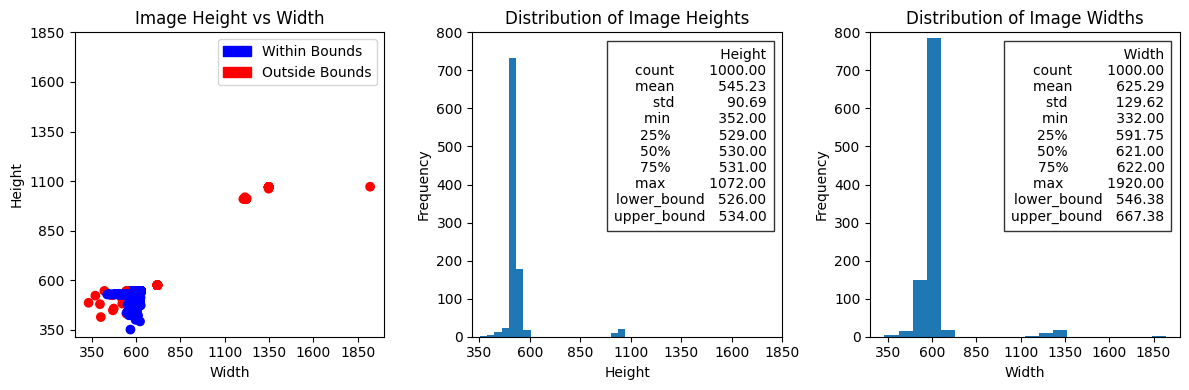

In [ ]:
import matplotlib.patches as mpatches

# Create a DataFrame with heights and widths
df = pd.DataFrame({'Height': heights, 'Width': widths})

# Generate the summary statistics
summary = round(df.describe(), 2)

# Calculate the lower bound and upper bound
q1 = summary.loc['25%']
q3 = summary.loc['75%']
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Add the lower bound and upper bound to the summary
summary.loc['lower_bound'] = round(lower_bound,2)
summary.loc['upper_bound'] = round(upper_bound,2)

# Create a figure with two subplots and a scatter plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the scatter plot of heights and widths
colors = np.where((heights >= lower_bound['Height']) & (heights <= upper_bound['Height']) |
                  (widths >= lower_bound['Width']) & (widths <= upper_bound['Width']), 'blue', 'red')

scatter = axs[0].scatter(widths, heights, c=colors)
axs[0].set_xlabel('Width')
axs[0].set_ylabel('Height')
axs[0].set_title('Image Height vs Width')
axs[0].set_xticks(np.arange(350, 1920, 250))
axs[0].set_yticks(np.arange(350, 1920, 250))

# Create legend labels
legend_labels = [mpatches.Patch(color='blue', label='Within Bounds'),
                 mpatches.Patch(color='red', label='Outside Bounds')]

# Add legend
axs[0].legend(handles=legend_labels)

# Plot the histogram of heights
axs[1].hist(heights, bins=20)
axs[1].set_xlabel('Height')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Image Heights')
axs[1].set_xticks(np.arange(350, 1920, 250))
axs[1].text(0.95, 0.95, str(summary[['Height']]), transform=axs[1].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Plot the histogram of widths
axs[2].hist(widths, bins=20)
axs[2].set_xlabel('Width')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Distribution of Image Widths')
axs[2].text(0.95, 0.95,
            str(summary[['Width']]),
            transform=axs[2].transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
axs[2].set_xticks(np.arange(350, 1920, 250))

# Set the same vertical scale for both histograms
axs[1].set_ylim([0, 800])
axs[2].set_ylim([0, 800])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


The samples have different sizes ranging from 332x487 to 1920x1072 pixels. Both widths and heights are right-skewed and there are some extreme outliers at far end of heights and widths.

To calculate the outliers, the lower bound and upper bound are first calculated using the interquartile range (IQR). The IQR is obtained by subtracting the 25th percentile (Q1) from the 75th percentile (Q3). The lower bound is calculated as Q1 - 1.5 * IQR, and the upper bound is calculated as Q3 + 1.5 * IQR.

Later on, we will need to resize all the images to the same size before fitting to a model for compatibility with the model architecture. Resizing the images to size within the boundary range can be an option.

### Check polyp positions

Let's make use of the mask bounding box coordinates and see in which region are the polyps usually located at. An image can be divided to 9 grids, we then iterate over the bounding box data, calculate the center coordinates, and determine the grid cell for each bounding box based on the center coordinates.

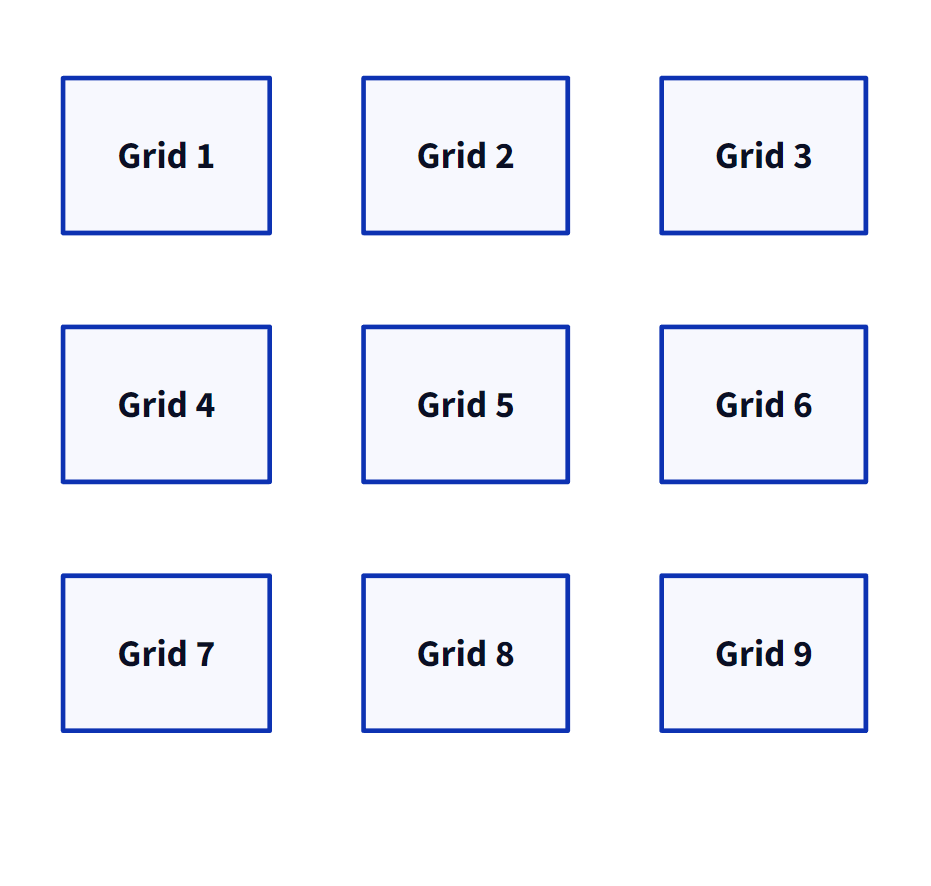

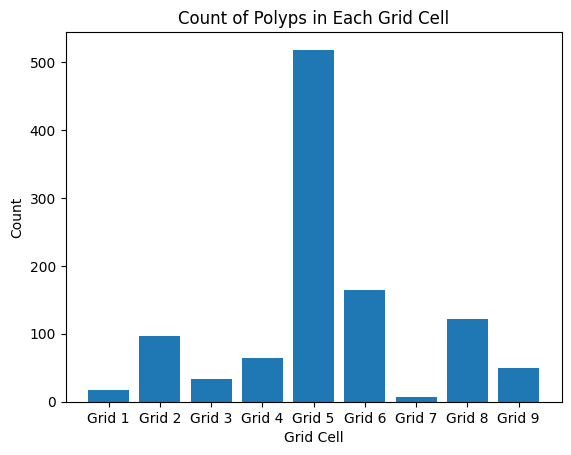

In [ ]:
# Initialize a 3x3 grid to store the grid counts
import json
grid_counts = [[0] * 3 for _ in range(3)]
images_json= os.path.join(data_dir, "kavsir_bboxes.json")
# Read the JSON file
with open(images_json, 'r') as json_file:
    kavsir_bboxes = json.load(json_file)
# Iterate over the bounding box data
for image_data in kavsir_bboxes.values():
    height = image_data['height']
    width = image_data['width']
    for bbox in image_data['bbox']:
        # Extract the coordinates
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']

        # Calculate the center coordinates
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2

        # Determine the grid cell based on the center coordinates
        grid_row = int(y_center / (height / 3))
        grid_col = int(x_center / (width / 3))

        # Increment the count for the corresponding grid cell
        grid_counts[grid_row][grid_col] += 1

# Flatten the grid counts into a 1D list
counts = [count for row in grid_counts for count in row]

# Define the labels for the grid cells
labels = ['Grid {}'.format(i+1) for i in range(9)]

# Create a bar chart
x_pos = np.arange(len(labels))
plt.bar(x_pos, counts, align='center')

# Set the axis labels and title
plt.xlabel('Grid Cell')
plt.ylabel('Count')
plt.title('Count of Polyps in Each Grid Cell')

# Set the x-axis tick labels
plt.xticks(x_pos, labels)

# Display the plot
plt.show()

We can see most polyps are located in the center of the image (Grid2 = top-center, Grid5 = center-center, Grid8 = bottom-center) and least on the left side of the image (Grid1 = top-left, Grid4 = center-left, Grid7 = bottom-left)

We can better generalize our polyp position with position augmentation techniques such as flips, rotations, and translation.

### Check polyp size and count

We can get an idea of the polyp size by calculating the relative size of a bounding box. We can divide the area of the bounding box by the total area of the image, which the area of a bounding box can be computed by multiplying its width by its height.

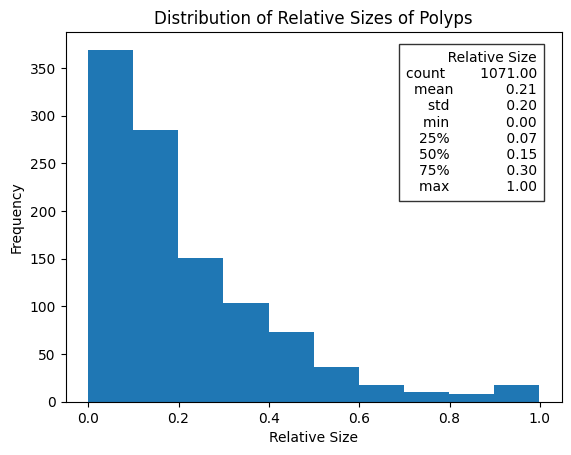

In [ ]:
# Empty list to store all the relative sizes
relative_sizes = []

# Iterate over the bounding box data
for image_data in kavsir_bboxes.values():
    height = image_data['height']
    width = image_data['width']
    for bbox in image_data['bbox']:
        # Extract the coordinates
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']

        # Calculate the width and height of the bounding box
        bbox_width = xmax - xmin
        bbox_height = ymax - ymin

        # Calculate the area of the bounding box
        bbox_area = bbox_width * bbox_height

        # Calculate the area of the image
        image_area = height * width

        # Calculate the relative size of the bounding box
        relative_size = bbox_area / image_area

        # Append the relative size to the list
        relative_sizes.append(relative_size)

# Calculate the summary statistics
summary = pd.DataFrame({'Relative Size': relative_sizes}).describe().round(2)

# Plot the histogram of relative sizes
n, bins, patches = plt.hist(relative_sizes)
plt.xlabel('Relative Size')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Sizes of Polyps')

# Add the summary statistics to the plot as text annotations
summary_text = str(summary[['Relative Size']])
plt.text(0.95, 0.95,
         summary_text,
         transform=plt.gca().transAxes,
         ha='right', va='top',
         bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})

# Display the plot
plt.show()

Most relative sizes are concentrated between 0.07 to 0.30, meaning that most polyps occupy 7% to 30% of the entire image.  There are very few images with polyps occupying greater than 50% (or more) of the image.

We can also notice that the count of the polyp is 1071 when we just have 1000 images, this is because some images contain more than one polyp.For example:

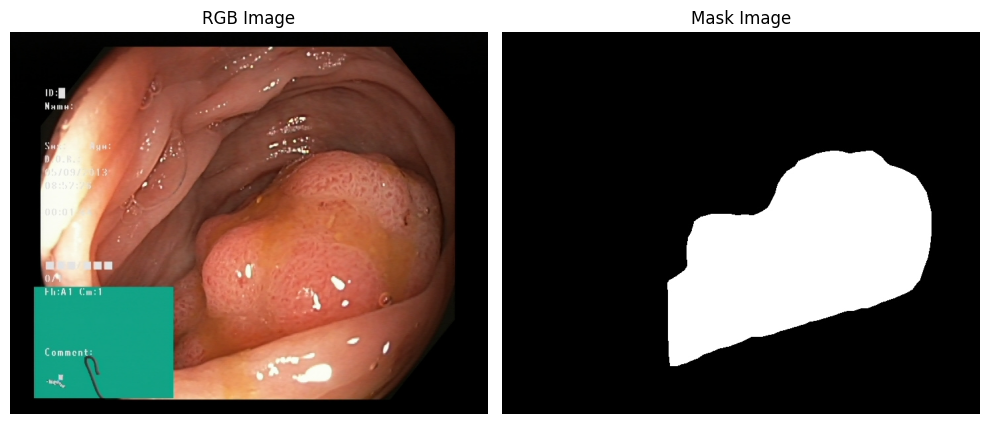

In [ ]:
# Load RGB image and mask
image_path = os.path.join(images_dir, images_files[-7])
mask_path = os.path.join(masks_dir, masks_files[-7])
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the RGB image
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('RGB Image')
axs[0].axis('off')

# Plot the mask image
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask Image')
axs[1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

Overall, we can also better generalize our polyp size with position augmentation techniques such as crops and zooms.

### Check image hue, brightnesss, and saturation

Describing colors using hue, saturation and brightness (also at times referred to as hue, saturation and lightness, or HSL) is a convenient way to organize differences in colors as perceived by humans. Explanation to each of the categories are:
- **HUE** - Hue refers to the pure state of color. It is the natural color without mixing or modifying. The unmixed or unmodified property of color is Hue. In other words, Hue is the name by which we identify a color. Also Hue is the property by which we distinguish it from other colors.

- **BRIGHTNESS (value)** - Value is the relative darkness or lightness of a color. This can be illustrated by the evidence of black and white photography of colored objects. The different colors will have different tonal values.
A scale which shows the sequence in tonal values of colors ( from White to Gray to Black) is called the GRAY SCALE. The tonal value of each color can be further affected by adding either black or white. The gradual adding of black color produces 'shades'. The gradual adding of white color produces 'Tints'. Maximum addition of white gives high tonal value. The middle colors between high and low is known as middle tones or half tone.

- **SATURATION (intensity)** - Chrome or saturation which indicates the purity of color is known as the intensity. Colors which are mixed and have ultimate degree of vividness are said to exhibit 'high intensity'. Two colors may have same hue value but yet differ in color strength.

In OpenCV, Hue has values from 0 to 180, Saturation and Value from 0 to 255. Thus, OpenCV uses HSV ranges between (0-180, 0-255, 0-255). In OpenCV, the H values 179, 178, 177 and so on are as close to the true RED as H value 1, 2, 3 and so on. Below is an example of HSV color map:

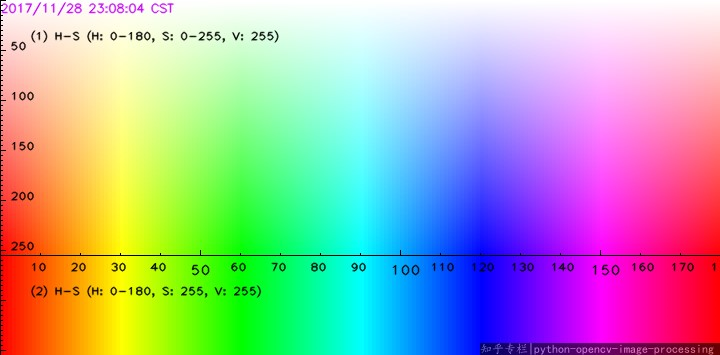

Let's plot histograms and see how are the three color components distributed for all of our RGB images

100%|██████████| 1000/1000 [00:08<00:00, 117.17it/s]


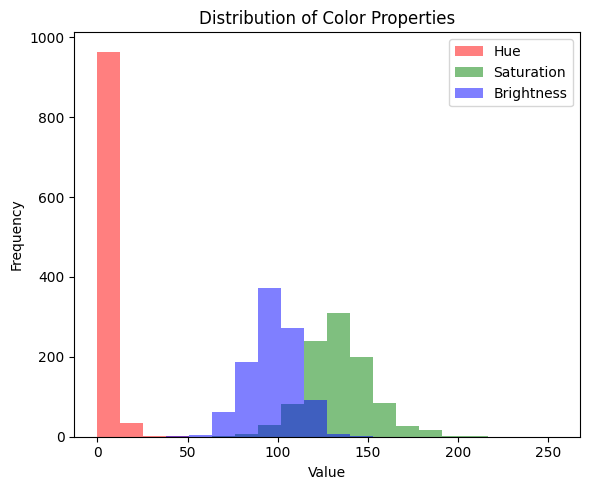

Hue  Saturation  Brightness
count     1000.00     1000.00     1000.00
mean         9.03      134.14       97.48
std          2.40       18.28       13.46
min          4.28       75.41       48.13
25%          7.82      122.69       88.91
50%          8.65      133.69       97.60
75%          9.71      144.66      106.68
max         48.53      206.39      151.25
skewness     6.69        0.29       -0.23

In [ ]:
# Calculate the average brightness, hue, and saturation of the images
brightness_values = []
hue_values = []
saturation_values = []

# Create a progress bar for the loop
for image_file in tqdm(images_files):
    # Load the image
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)

    # Convert the image to different color spaces
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the average pixel intensities
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    brightness = np.mean(gray)
    brightness_values.append(brightness)

    # Calculate the average hue value
    hue = np.mean(hsv_image[:, :, 0])
    hue_values.append(hue)

    # Calculate the average saturation value
    saturation = np.mean(hsv_image[:, :, 1])
    saturation_values.append(saturation)

# Set the same range for the x-axis
x_axis_range = (0, 255)  # Adjust this range as per your requirement

# Display the histograms of hue, saturation, and brightness values
plt.figure(figsize=(6, 5))
n, bins, patches = plt.hist(hue_values, bins=20, range=x_axis_range, color='r', alpha=0.5, label='Hue')
plt.hist(saturation_values, bins=20, range=x_axis_range, color='g', alpha=0.5, label='Saturation')
plt.hist(brightness_values, bins=20, range=x_axis_range, color='b', alpha=0.5, label='Brightness')

# Set the labels, title, and legend
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Color Properties')
plt.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# Create a DataFrame with hue, saturation, and brightness values
df = pd.DataFrame({'Hue': hue_values, 'Saturation': saturation_values, 'Brightness': brightness_values})

# Generate the summary statistics including skewness
summary = round(df.describe(), 2)
summary.loc['skewness'] = round(df.skew(), 2)

# Display the statistics
display(summary)


Let's analyze the hue, saturation, and brightness distribution.

**Hue**<br>
The hue distribution covers a wide range of values from 4.28 to 48.53. The 25th percentile (first quartile) of 7.82 and the 75th percentile (third quartile) of 9.71 suggest that most hue values fall within this range, which corresponds to red color. The longer tail towards higher hue values  indicaties that there's predominant color or color bias in that direction.


**Saturation**<br>
The distribution of saturation is fairly symmetric and has wide range of values from 75.41 to 206.39.The mean saturation value is 134.14, indicating a moderate level of saturation on average.

**Brightness**<br>
Similar to saturation, The fairly symmetric distribution of brightness indicates a relatively balanced distribution of values across the range of 48.13 to 151.25. The symmetric shape suggests that there is no strong bias towards high or low brightness values. The mean brightness value is 97.48, indicating a moderate brightness level on average.

When we get to image preprocessing, we can better generalize our hue, saturation, brightness with color augmentation.

## Data Preprocessing

### Prepare Image Dataset

We can see that our entire 1000 images and 1000 masks in two separate folders. Before fitting the images to our machine learning model, we will split the images and masks into train, validation, and test set, then apply image preprocessing and augmentation.

The purpose of a train-test split is to assess the performance and generalization ability of a machine learning model. When building a model, it is crucial to evaluate its performance on data that it has not seen during the training phase. This helps determine if the model can effectively generalize its learnings to new, unseen data.

### Split and Move Images

In [ ]:
# Directories
data_dir = '/content/drive/MyDrive/Project-Deep-Learning/Kvasir-SEG'  # Change this to your original dataset directory
new_data_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg'  # Change this to your new dataset directory

# Create train, valid, test directories
train_dir = os.path.join(new_data_dir, 'train')
valid_dir = os.path.join(new_data_dir, 'valid')
test_dir = os.path.join(new_data_dir, 'test')

for directory in [train_dir, valid_dir, test_dir]:
    os.makedirs(os.path.join(directory, 'images'), exist_ok=True)
    os.makedirs(os.path.join(directory, 'masks'), exist_ok=True)

# List all image and mask filenames
images_dir = os.path.join(data_dir, 'images')
masks_dir = os.path.join(data_dir, 'masks')

image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

# Check if image and mask filenames match
matching_files = [img for img in image_files if img in mask_files]
mismatched_files = [img for img in image_files if img not in mask_files]

# Split data into train, valid, and test sets
train_images, test_val_images = train_test_split(matching_files, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

# Move images and masks to respective train, valid, test subdirectories
def move_files_to_folder(image_files, mask_files, src_image_dir, src_mask_dir, dest_image_dir, dest_mask_dir):
    for img_file, mask_file in zip(image_files, mask_files):
        shutil.move(os.path.join(src_image_dir, img_file), os.path.join(dest_image_dir, 'images', img_file))
        shutil.move(os.path.join(src_mask_dir, mask_file), os.path.join(dest_mask_dir, 'masks', mask_file))

# Move files only if they are in both images and masks folders
move_files_to_folder(train_images, train_images, images_dir, masks_dir, train_dir, train_dir)
move_files_to_folder(val_images, val_images, images_dir, masks_dir, valid_dir, valid_dir)
move_files_to_folder(test_images, test_images, images_dir, masks_dir, test_dir, test_dir)


### Change Extension

In [ ]:
# Define the directories
train_images_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg/train/images'
train_masks_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg/train/masks'
test_images_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg/test/images'
test_masks_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg/test/masks'
valid_images_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg/valid/images'
valid_masks_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg/valid/masks'

# Function to change file extensions to .png
def change_extension_to_png(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.bmp') or filename.endswith('.gif'):
            # Rename the file with a .png extension
            os.rename(os.path.join(directory, filename), os.path.join(directory, os.path.splitext(filename)[0] + '.png'))

# Change extensions for train images and masks
change_extension_to_png(train_images_dir)
change_extension_to_png(train_masks_dir)

# Change extensions for test images and masks
change_extension_to_png(test_images_dir)
change_extension_to_png(test_masks_dir)

# Change extensions for validation images and masks
change_extension_to_png(valid_images_dir)
change_extension_to_png(valid_masks_dir)

### Data Generator

In [ ]:
# Directories
train_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg/train'
test_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg/test'
val_dir = '/content/drive/MyDrive/Project-Deep-Learning/dataset-kvasir-seg/valid'

# Augmentation parameters
rescale_factor = 1.0 / 255.0

# Train data generator with augmentation
train_data_generator = ImageDataGenerator(
    rescale=rescale_factor,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.7, 1.3],
    fill_mode='reflect')

# Test and validation data generators without augmentation
test_data_generator = ImageDataGenerator(rescale=rescale_factor)
valid_data_generator = ImageDataGenerator(rescale=rescale_factor)

# Train generators for images and masks
train_image_generator = train_data_generator.flow_from_directory(
    train_dir,
    classes=['images'],
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    seed=42)

train_mask_generator = train_data_generator.flow_from_directory(
    train_dir,
    classes=['masks'],
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    seed=42,
    color_mode='grayscale')

# Validation generators for images and masks
valid_image_generator = valid_data_generator.flow_from_directory(
    val_dir,
    classes=['images'],
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    seed=42)

valid_mask_generator = valid_data_generator.flow_from_directory(
    val_dir,
    classes=['masks'],
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    seed=42,
    color_mode='grayscale')

# Test generators for images and masks
test_image_generator = test_data_generator.flow_from_directory(
    test_dir,
    classes=['images'],
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    seed=42)

test_mask_generator = test_data_generator.flow_from_directory(
    test_dir,
    classes=['masks'],
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    seed=42,
    color_mode='grayscale')



Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [ ]:
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(valid_image_generator, valid_mask_generator)

In [ ]:
# Get the number of samples in the train images
train_samples = train_image_generator.samples

# Get the batch size
batch_size = train_image_generator.batch_size

# Calculate the number of steps per epoch (number of batches)
train_steps = train_samples / batch_size

# Print the number of samples, batch size, and number of batches
print("Train Images")
print("Number of samples:", train_samples)
print("Batch size:", batch_size)
print("Number of batches (train steps):", round(train_steps))

Train Images
Number of samples: 800
Batch size: 32
Number of batches (train steps): 25


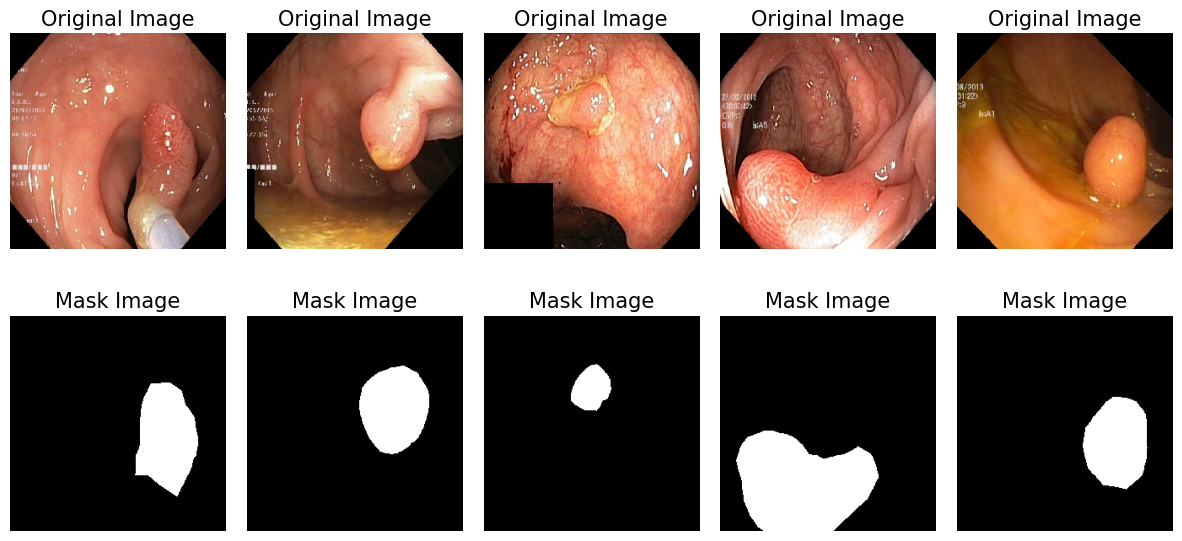

In [ ]:
import matplotlib.pyplot as plt

# Set the number of rows and columns for the grid
num_rows = 2
num_cols = 5
total_images = num_rows * num_cols  # total of 10 images to display

# Plot the images and masks in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

# Get the test batch
test_batch_images = test_image_generator.next()
test_batch_masks = test_mask_generator.next()

# Iterate over the images in the test batch and plot them in the grid
for i in range(num_cols):
    # Plot the original image with a title
    axes[0, i].imshow(test_batch_images[i], cmap='gray')
    axes[0, i].set_title('Original Image', fontsize=15)
    axes[0, i].axis('off')

    # Plot the corresponding mask image with a title
    axes[1, i].imshow(test_batch_masks[i], cmap='gray')
    axes[1, i].set_title('Mask Image', fontsize=15)
    axes[1, i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()


## **Architectures**

### Evaluation Metrics

In [ ]:
# Define Dice coefficient for evaluating segmentation performance
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

# Define Dice loss based on Dice coefficient
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

# Define IoU (Intersection over Union) coefficient
def iou_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Define IoU loss based on IoU coefficient
def iou_loss(y_true, y_pred):
    loss = 1 - iou_coefficient(y_true, y_pred)
    return loss

### Custom Loss Function

In [ ]:
def weighted_bincrossentropy(true, pred, weight_zero = 0.25, weight_one = 1):

    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)

    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy

    return keras.backend.mean(weighted_bin_crossentropy)

### VGG19 (Backbone for FCN16 and FCN8)


In [ ]:
input_layer = keras.Input(shape=(256, 256, 3))

# VGG Model backbone with pre-trained ImageNet weights.

vgg_model = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Extracting different outputs from same model
fcn_backbone = keras.models.Model(
    inputs=vgg_model.layers[1].input,
    outputs=[
        vgg_model.get_layer(block_name).output
        for block_name in ["block3_pool", "block4_pool", "block5_pool"]
    ],
)

# Setting backbone to be non-trainable
fcn_backbone.trainable = False

x = fcn_backbone(input_layer)

# Converting Dense layers to Conv2D layers
units = [4096, 4096]
dense_convs = []

for filter_idx in range(len(units)):
    dense_conv = keras.layers.Conv2D(
        filters=units[filter_idx],
        kernel_size=(7, 7) if filter_idx == 0 else (1, 1),
        strides=(1, 1),
        activation="relu",
        padding="same",
        use_bias=False,
        kernel_initializer=tf.constant_initializer(1.0),
    )
    dense_convs.append(dense_conv)
    dropout_layer = keras.layers.Dropout(0.5)
    dense_convs.append(dropout_layer)

dense_convs = keras.Sequential(dense_convs)
dense_convs.trainable = False

x[-1] = dense_convs(x[-1])

pool3_output, pool4_output, pool5_output = x

80134624/80134624 [==============================] - 5s 0us/step


### FCN16

In [ ]:
# 1x1 convolution to set channels = number of classes
pool5 = keras.layers.Conv2D(
    filters=1,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="relu",
)

# Get Softmax outputs for all classes
fcn32s_conv_layer = keras.layers.Conv2D(
    filters=1,
    kernel_size=(1, 1),
    activation="sigmoid",
    padding="same",
    strides=(1, 1),
)

# Up-sample to original image size
fcn32s_upsampling = keras.layers.UpSampling2D(
    size=(32, 32),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)

final_fcn32s_pool = pool5(pool5_output)
final_fcn32s_output = fcn32s_conv_layer(final_fcn32s_pool)
final_fcn32s_output = fcn32s_upsampling(final_fcn32s_output)

fcn32s_model = keras.Model(inputs=input_layer, outputs=final_fcn32s_output)

In [ ]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool4 = keras.layers.Conv2D(
    filters=1,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="linear",
    kernel_initializer=keras.initializers.Zeros(),
)(pool4_output)

# Intermediate up-sample
pool5 = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)(final_fcn32s_pool)

# Get Softmax outputs for all classes
fcn16s_conv_layer = keras.layers.Conv2D(
    filters=1,
    kernel_size=(1, 1),
    activation="sigmoid",
    padding="same",
    strides=(1, 1),
)

# Up-sample to original image size
fcn16s_upsample_layer = keras.layers.UpSampling2D(
    size=(16, 16),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)

# Add intermediate outputs
final_fcn16s_pool = keras.layers.Add()([pool4, pool5])
final_fcn16s_output = fcn16s_conv_layer(final_fcn16s_pool)
final_fcn16s_output = fcn16s_upsample_layer(final_fcn16s_output)

fcn16s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn16s_output)
fcn16s_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 32, 32, 256),        2002438   ['input_1[0][0]']             
                              (None, 16, 16, 512),        4                                       
                              (None, 8, 8, 512)]                                                  
                                                                                                  
 sequential (Sequential)     (None, 8, 8, 4096)           1195376   ['model[0][2]']               
                                                          64                                

In [ ]:
fcn16s_optimizer = keras.optimizers.AdamW(
    learning_rate=1e-3, weight_decay=1e-4)
fcn16s_loss = weighted_bincrossentropy
fcn16s_model.compile(optimizer=fcn16s_optimizer,
                    loss=fcn16s_loss,
                    metrics=['accuracy', dice_coefficient, dice_loss, iou_coefficient, iou_loss])

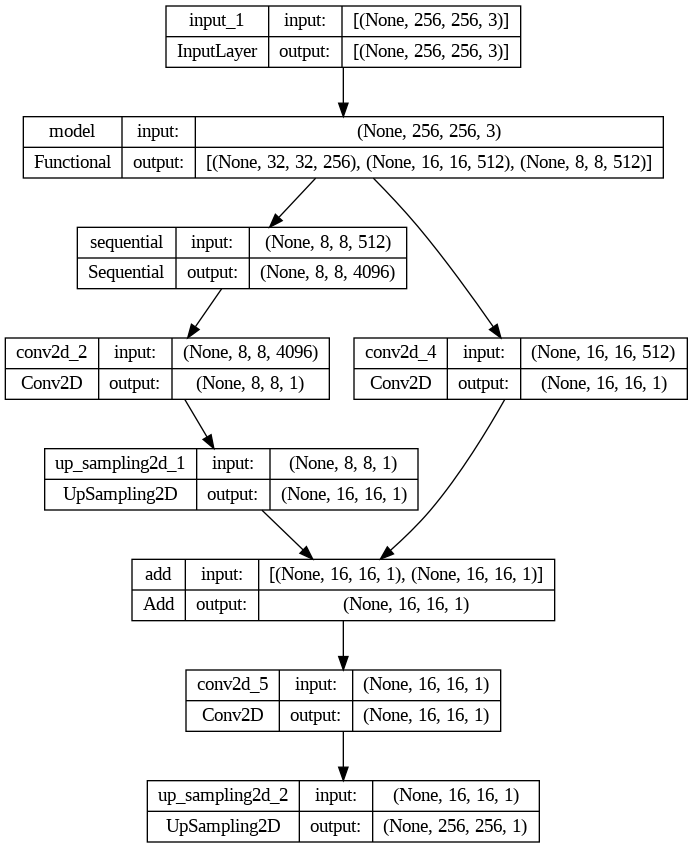

In [ ]:
plot_model(fcn16s_model, to_file='FCN16_Model.png', show_shapes=True)

In [ ]:
steps_per_epoch = 800//32
validation_steps = 100//32

checkpoint_path = '/content/drive/MyDrive/Project-Deep-Learning/FCN16.h5'
# Callbacks
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_iou_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)

start = time.time()
fcn16s_history = fcn16s_model.fit(train_generator,steps_per_epoch=steps_per_epoch,
                                  epochs=80, validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  callbacks=[model_checkpoint, early_stopping, reduce_lr],
                                  batch_size = 32)
end = time.time()
print('Computational time: ', end-start, 's')

Epoch 1/80
25/25 [==============================] - ETA: 0s - loss: 2.9825 - accuracy: 0.1182 - dice_coefficient: 0.2554 - dice_loss: 0.7446 - iou_coefficient: 0.1468 - iou_loss: 0.8532
Epoch 1: val_iou_loss improved from inf to 0.84330, saving model to /content/drive/MyDrive/Project-Deep-Learning/FCN16.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.Constant'>, which may lead to improper serialization.
  warnings.warn(


25/25 [==============================] - 45s 1s/step - loss: 2.9825 - accuracy: 0.1182 - dice_coefficient: 0.2554 - dice_loss: 0.7446 - iou_coefficient: 0.1468 - iou_loss: 0.8532 - val_loss: 3.2156 - val_accuracy: 0.1529 - val_dice_coefficient: 0.2709 - val_dice_loss: 0.7291 - val_iou_coefficient: 0.1567 - val_iou_loss: 0.8433 - lr: 0.0010
Epoch 2/80
25/25 [==============================] - ETA: 0s - loss: 2.1748 - accuracy: 0.3319 - dice_coefficient: 0.2446 - dice_loss: 0.7554 - iou_coefficient: 0.1399 - iou_loss: 0.8601
Epoch 2: val_iou_loss did not improve from 0.84330
25/25 [==============================] - 24s 984ms/step - loss: 2.1748 - accuracy: 0.3319 - dice_coefficient: 0.2446 - dice_loss: 0.7554 - iou_coefficient: 0.1399 - iou_loss: 0.8601 - val_loss: 0.2185 - val_accuracy: 0.8505 - val_dice_coefficient: 0.2173 - val_dice_loss: 0.7827 - val_iou_coefficient: 0.1229 - val_iou_loss: 0.8771 - lr: 0.0010
Epoch 3/80
25/25 [==============================] - ETA: 0s - loss: 0.2260 -

In [ ]:
custom_objects = {'weighted_bincrossentropy': weighted_bincrossentropy, 'dice_coefficient': dice_coefficient, 'dice_loss': dice_loss, 'iou_coefficient': iou_coefficient, 'iou_loss': iou_loss}
loaded_fcn16s = tf.keras.models.load_model('/content/drive/MyDrive/Project-Deep-Learning/FCN16.h5', custom_objects = custom_objects)

1/1 [==============================] - 0s 247ms/step
Random indices: [3, 17, 5, 26, 6]


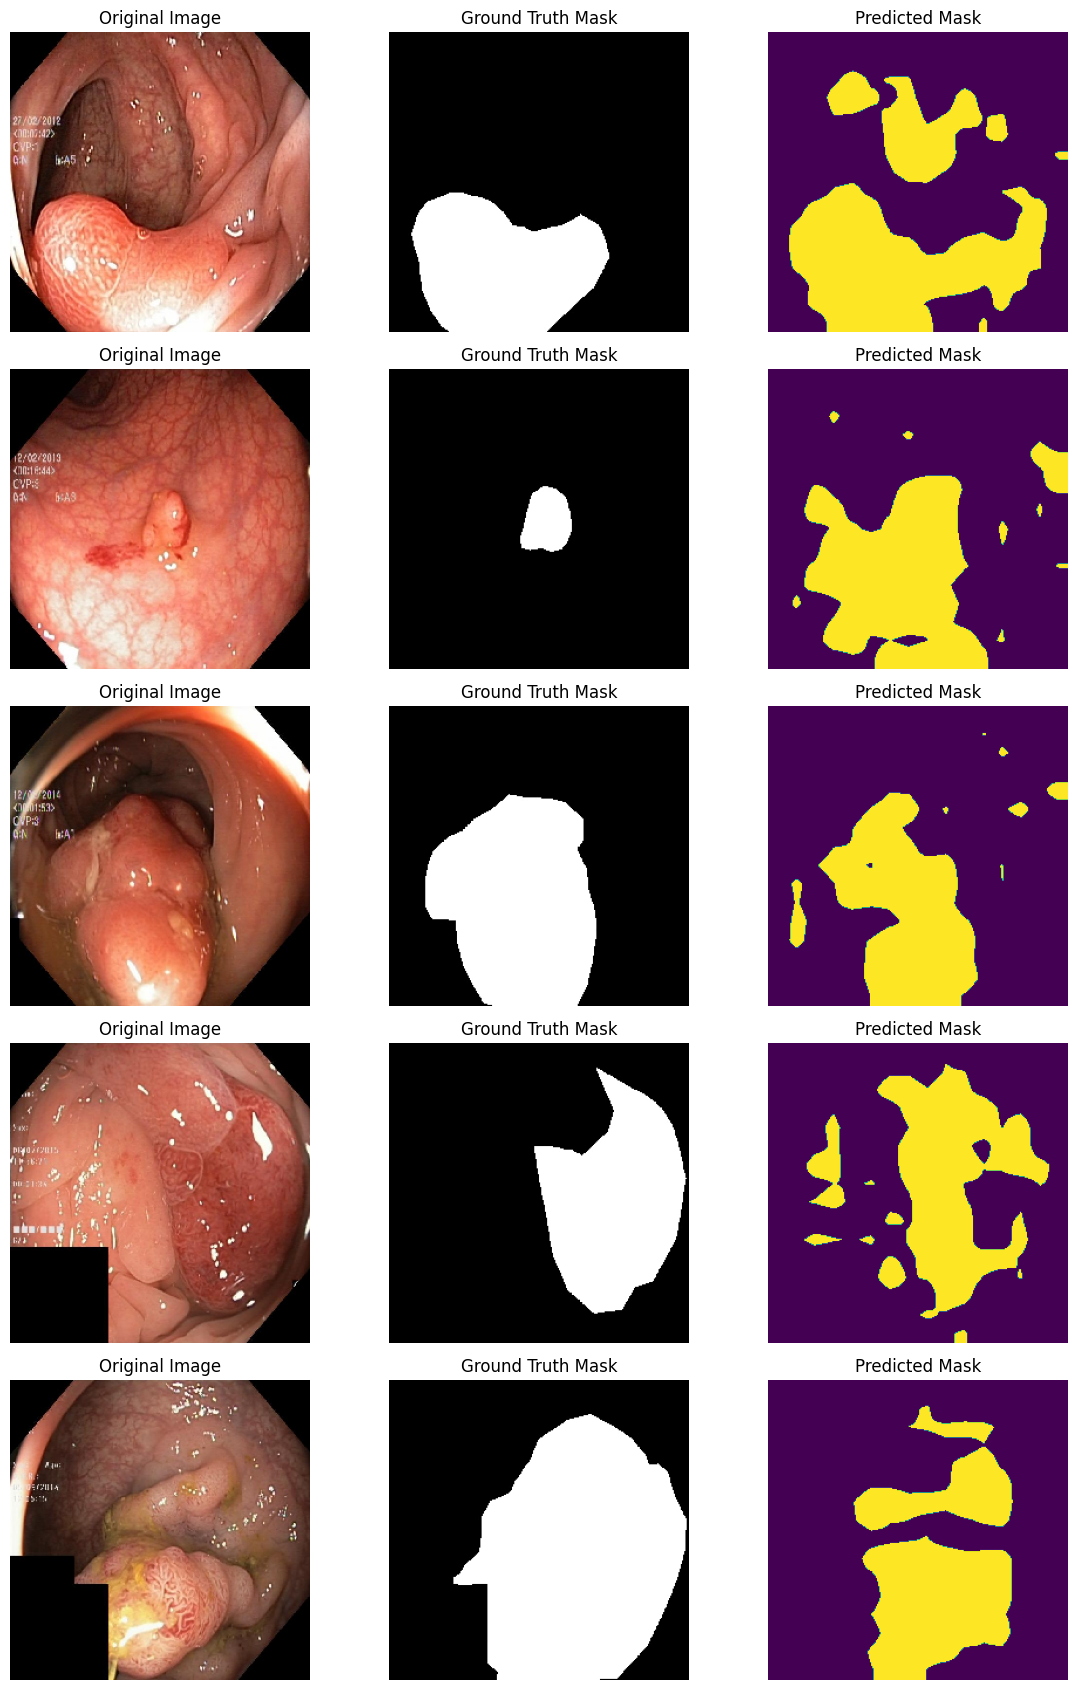

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Reset the generators
test_image_generator.reset()
test_mask_generator.reset()

# Get the corresponding test image and mask (from only 1 batch)
test_image = next(test_image_generator)
test_mask = next(test_mask_generator)

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_image)), 5)

# Generate predictions for the test image
prediction = loaded_fcn16s.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_image[random_index])  # test_image is a batch, we extract the first image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_mask[random_index], cmap='gray')  # test_mask is a batch, we extract the first mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_prediction[random_index], cmap='viridis')  # binary_prediction is a batch, we extract the first prediction
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


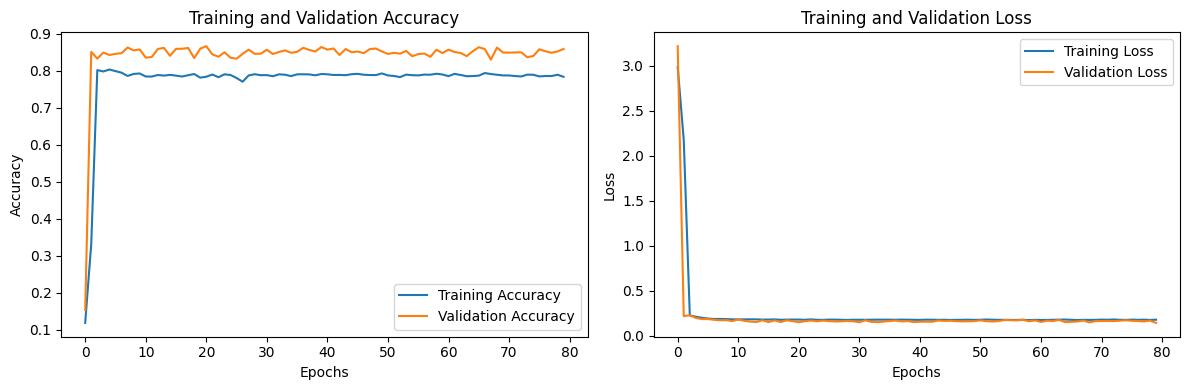

In [ ]:
train_accuracy = fcn16s_history.history['accuracy']
val_accuracy = fcn16s_history.history['val_accuracy']
train_loss = fcn16s_history.history['loss']
val_loss = fcn16s_history.history['val_loss']

# Plot the learning curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### FCN8

In [ ]:
# 1x1 convolution to set channels = number of classes
# Followed from the original Caffe implementation
pool3 = keras.layers.Conv2D(
    filters=1,
    kernel_size=(1, 1),
    padding="same",
    strides=(1, 1),
    activation="linear",
    kernel_initializer=keras.initializers.Zeros(),
)(pool3_output)

# Intermediate up-sample
intermediate_pool_output = keras.layers.UpSampling2D(
    size=(2, 2),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)(final_fcn16s_pool)

# Get Softmax outputs for all classes
fcn8s_conv_layer = keras.layers.Conv2D(
    filters=1,
    kernel_size=(1, 1),
    activation="sigmoid",
    padding="same",
    strides=(1, 1),
)

# Up-sample to original image size
fcn8s_upsample_layer = keras.layers.UpSampling2D(
    size=(8, 8),
    data_format=keras.backend.image_data_format(),
    interpolation="bilinear",
)

# Add intermediate outputs
final_fcn8s_pool = keras.layers.Add()([pool3, intermediate_pool_output])
final_fcn8s_output = fcn8s_conv_layer(final_fcn8s_pool)
final_fcn8s_output = fcn8s_upsample_layer(final_fcn8s_output)

fcn8s_model = keras.models.Model(inputs=input_layer, outputs=final_fcn8s_output)

In [ ]:
fcn8s_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 32, 32, 256),        2002438   ['input_1[0][0]']             
                              (None, 16, 16, 512),        4                                       
                              (None, 8, 8, 512)]                                                  
                                                                                                  
 sequential (Sequential)     (None, 8, 8, 4096)           1195376   ['model[0][2]']               
                                                          64                                

In [ ]:
fcn8s_optimizer = keras.optimizers.AdamW(
    learning_rate=1e-3, weight_decay=1e-4)
fcn8s_loss = weighted_bincrossentropy
fcn8s_model.compile(optimizer=fcn8s_optimizer,
                    loss=fcn8s_loss,
                    metrics=['accuracy', dice_coefficient, dice_loss, iou_coefficient, iou_loss])

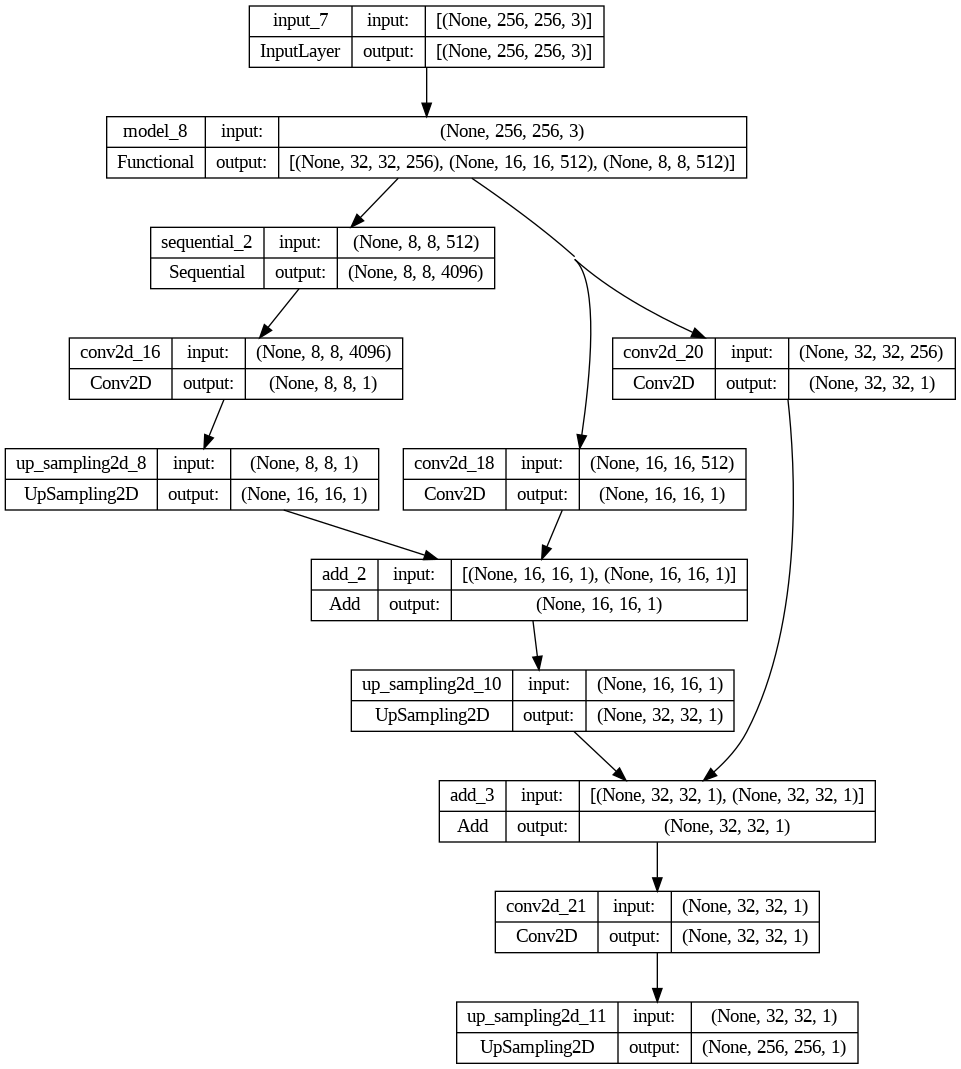

In [ ]:
plot_model(fcn8s_model, to_file='FCN8_Model.png', show_shapes=True, )

In [ ]:
steps_per_epoch = 800//32
validation_steps = 100//32

checkpoint_path = '/content/drive/MyDrive/Project-Deep-Learning/FCN8.h5'
# Callbacks
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_iou_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)

start = time.time()
fcn8s_history = fcn8s_model.fit(train_generator,steps_per_epoch=steps_per_epoch,
                                  epochs=80, validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  callbacks=[model_checkpoint, early_stopping, reduce_lr],
                                  batch_size = 32)
end = time.time()

Epoch 1/80
25/25 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.8199 - dice_coefficient: 0.2154 - dice_loss: 0.7846 - iou_coefficient: 0.1210 - iou_loss: 0.8790
Epoch 1: val_iou_loss improved from inf to 0.86712, saving model to /content/drive/MyDrive/Project-Deep-Learning/FCN8.h5
25/25 [==============================] - 26s 972ms/step - loss: 0.2379 - accuracy: 0.8199 - dice_coefficient: 0.2154 - dice_loss: 0.7846 - iou_coefficient: 0.1210 - iou_loss: 0.8790 - val_loss: 0.2459 - val_accuracy: 0.8353 - val_dice_coefficient: 0.2344 - val_dice_loss: 0.7656 - val_iou_coefficient: 0.1329 - val_iou_loss: 0.8671 - lr: 0.0010
Epoch 2/80
25/25 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.8392 - dice_coefficient: 0.2256 - dice_loss: 0.7744 - iou_coefficient: 0.1273 - iou_loss: 0.8727
Epoch 2: val_iou_loss did not improve from 0.86712
25/25 [==============================] - 21s 846ms/step - loss: 0.2199 - accuracy: 0.8392 - dice_coefficient: 0

In [ ]:
print('Computational time: ', end-start,'s')

Computational time:  1590.53240609169 s


In [ ]:
custom_objects = {'weighted_bincrossentropy': weighted_bincrossentropy, 'dice_coefficient': dice_coefficient, 'dice_loss': dice_loss, 'iou_coefficient': iou_coefficient, 'iou_loss': iou_loss}
loaded_fcn8s = tf.keras.models.load_model('/content/drive/MyDrive/Project-Deep-Learning/FCN8.h5', custom_objects = custom_objects)

1/1 [==============================] - 0s 192ms/step
Random indices: [3, 17, 5, 26, 6]


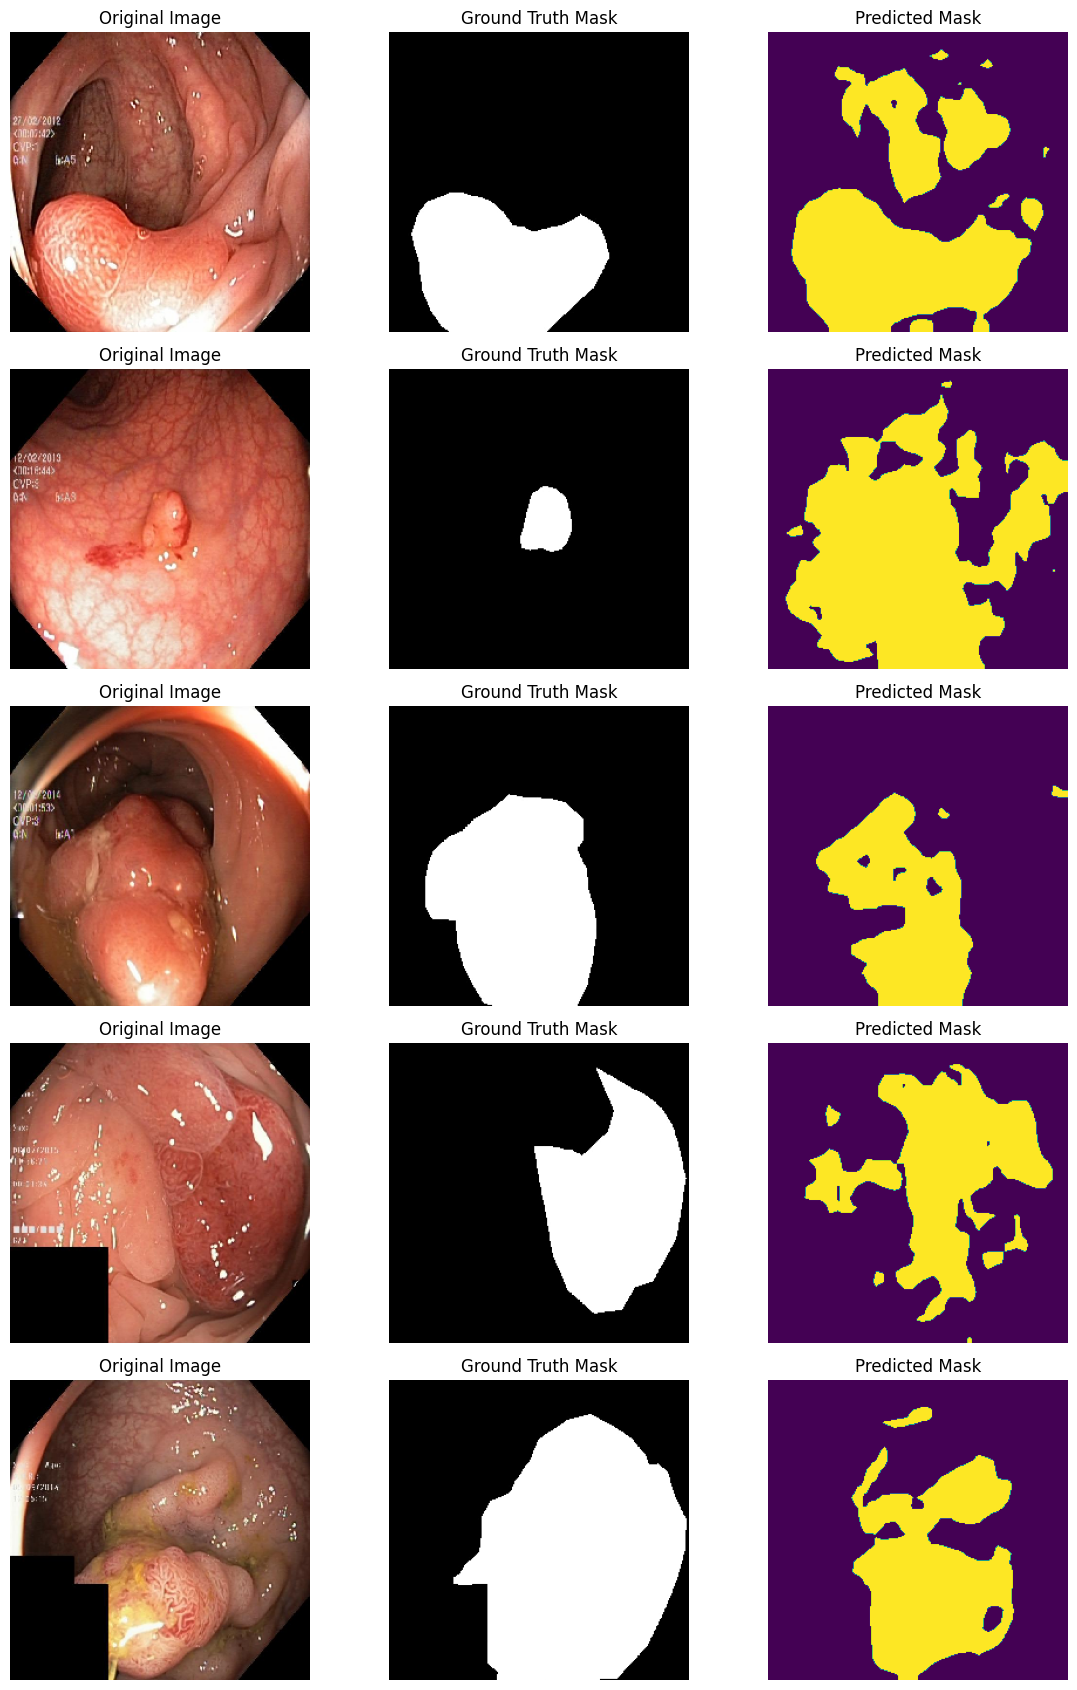

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Reset the generators
test_image_generator.reset()
test_mask_generator.reset()

# Get the corresponding test image and mask (from only 1 batch)
test_image = next(test_image_generator)
test_mask = next(test_mask_generator)

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_image)), 5)

# Generate predictions for the test image
prediction = loaded_fcn8s.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_image[random_index])  # test_image is a batch, we extract the first image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_mask[random_index], cmap='gray')  # test_mask is a batch, we extract the first mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_prediction[random_index], cmap='viridis')  # binary_prediction is a batch, we extract the first prediction
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


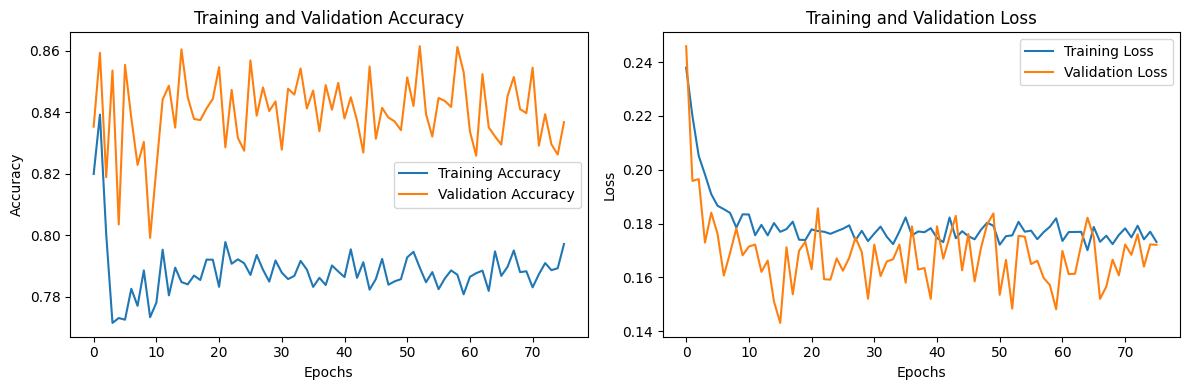

In [ ]:
train_accuracy = fcn8s_history.history['accuracy']
val_accuracy = fcn8s_history.history['val_accuracy']
train_loss = fcn8s_history.history['loss']
val_loss = fcn8s_history.history['val_loss']

# Plot the learning curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### FCN32

In [ ]:
def FCN32(num_classes):
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    ## Get the block 5 pooling layer from VGG
    pool5 = vgg.get_layer('block5_pool').output

    # Create a convolutionalized version of the first fully connected layer
    fc6 = Conv2D(4096, (7,7), kernel_initializer=TruncatedNormal(stddev=0.01),
                 kernel_regularizer=regularizers.l2(0.01), padding='same')(pool5)

    # Create a convolutionalized version of the second fully connected layer
    fc7 = Conv2D(4096, (1,1), kernel_initializer=TruncatedNormal(stddev=0.01),
                 kernel_regularizer=regularizers.l2(0.01), padding='same')(fc6)

    # Apply a 1x1 convolution and upsample to the original image shape
    layer_7_1x1 = Conv2D(num_classes, (1,1), kernel_initializer=TruncatedNormal(stddev=0.01),
                         kernel_regularizer=regularizers.l2(0.01), padding='same')(fc7)
    upsample1 = Conv2DTranspose(num_classes, (64,64), strides=32, kernel_initializer=TruncatedNormal(stddev=0.01),
                                kernel_regularizer=regularizers.l2(0.01), padding='same')(layer_7_1x1)

    # Add softmax activation
    out_layer = Activation('sigmoid')(upsample1)

    model = Model(inputs=vgg.input, outputs=out_layer)

    return model

FCN32_model = FCN32(num_classes=1)
FCN32_model.summary()


58889256/58889256 [==============================] - 2s 0us/step
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                           

In [ ]:
# Compile the Model
adam = Adam(learning_rate = 0.0001)
FCN32_model.compile(optimizer=adam, loss = weighted_bincrossentropy, metrics = ['accuracy', dice_coefficient, dice_loss, iou_coefficient, iou_loss])

In [ ]:
from PIL import ImageFont
font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 45)
# Visualize the model with the modified font size
visualkeras.layered_view(FCN32_model, to_file='FCN32_model.png', legend=True, font=font).show()

In [ ]:
steps_per_epoch = 800//32
validation_steps = 100//32
checkpoint_path = '/content/drive/MyDrive/Project-Deep-Learning/FCN32.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_iou_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)

# Fit the model using the data generators
start = time.time()
history = FCN32_model.fit(train_generator,
                          steps_per_epoch=steps_per_epoch,
                          epochs=80,
                          validation_data=val_generator,
                          validation_steps=validation_steps,
                          callbacks=[model_checkpoint, early_stopping, reduce_lr])
end = time.time()
print('Computational time: ', end-start, 's')

Epoch 1/80
25/25 [==============================] - ETA: 0s - loss: 74.5273 - accuracy: 0.6433 - dice_coefficient: 0.2244 - dice_loss: 0.7756 - iou_coefficient: 0.1266 - iou_loss: 0.8734
Epoch 1: val_iou_loss improved from inf to 0.86458, saving model to /content/drive/MyDrive/Project-Deep-Learning/FCN32.h5
25/25 [==============================] - 61s 2s/step - loss: 74.5273 - accuracy: 0.6433 - dice_coefficient: 0.2244 - dice_loss: 0.7756 - iou_coefficient: 0.1266 - iou_loss: 0.8734 - val_loss: 57.3037 - val_accuracy: 0.7468 - val_dice_coefficient: 0.2385 - val_dice_loss: 0.7615 - val_iou_coefficient: 0.1354 - val_iou_loss: 0.8646 - lr: 1.0000e-04
Epoch 2/80
25/25 [==============================] - ETA: 0s - loss: 45.5841 - accuracy: 0.6973 - dice_coefficient: 0.2230 - dice_loss: 0.7770 - iou_coefficient: 0.1257 - iou_loss: 0.8743
Epoch 2: val_iou_loss did not improve from 0.86458
25/25 [==============================] - 23s 925ms/step - loss: 45.5841 - accuracy: 0.6973 - dice_coeffic

In [ ]:
custom_objects = {'weighted_bincrossentropy': weighted_bincrossentropy, 'dice_coefficient': dice_coefficient, 'dice_loss': dice_loss, 'iou_coefficient': iou_coefficient, 'iou_loss': iou_loss}
loaded_fcn32 = tf.keras.models.load_model('/content/drive/MyDrive/Project-Deep-Learning/FCN32.h5', custom_objects = custom_objects)

1/1 [==============================] - 0s 158ms/step
Random indices: [3, 17, 5, 26, 6]


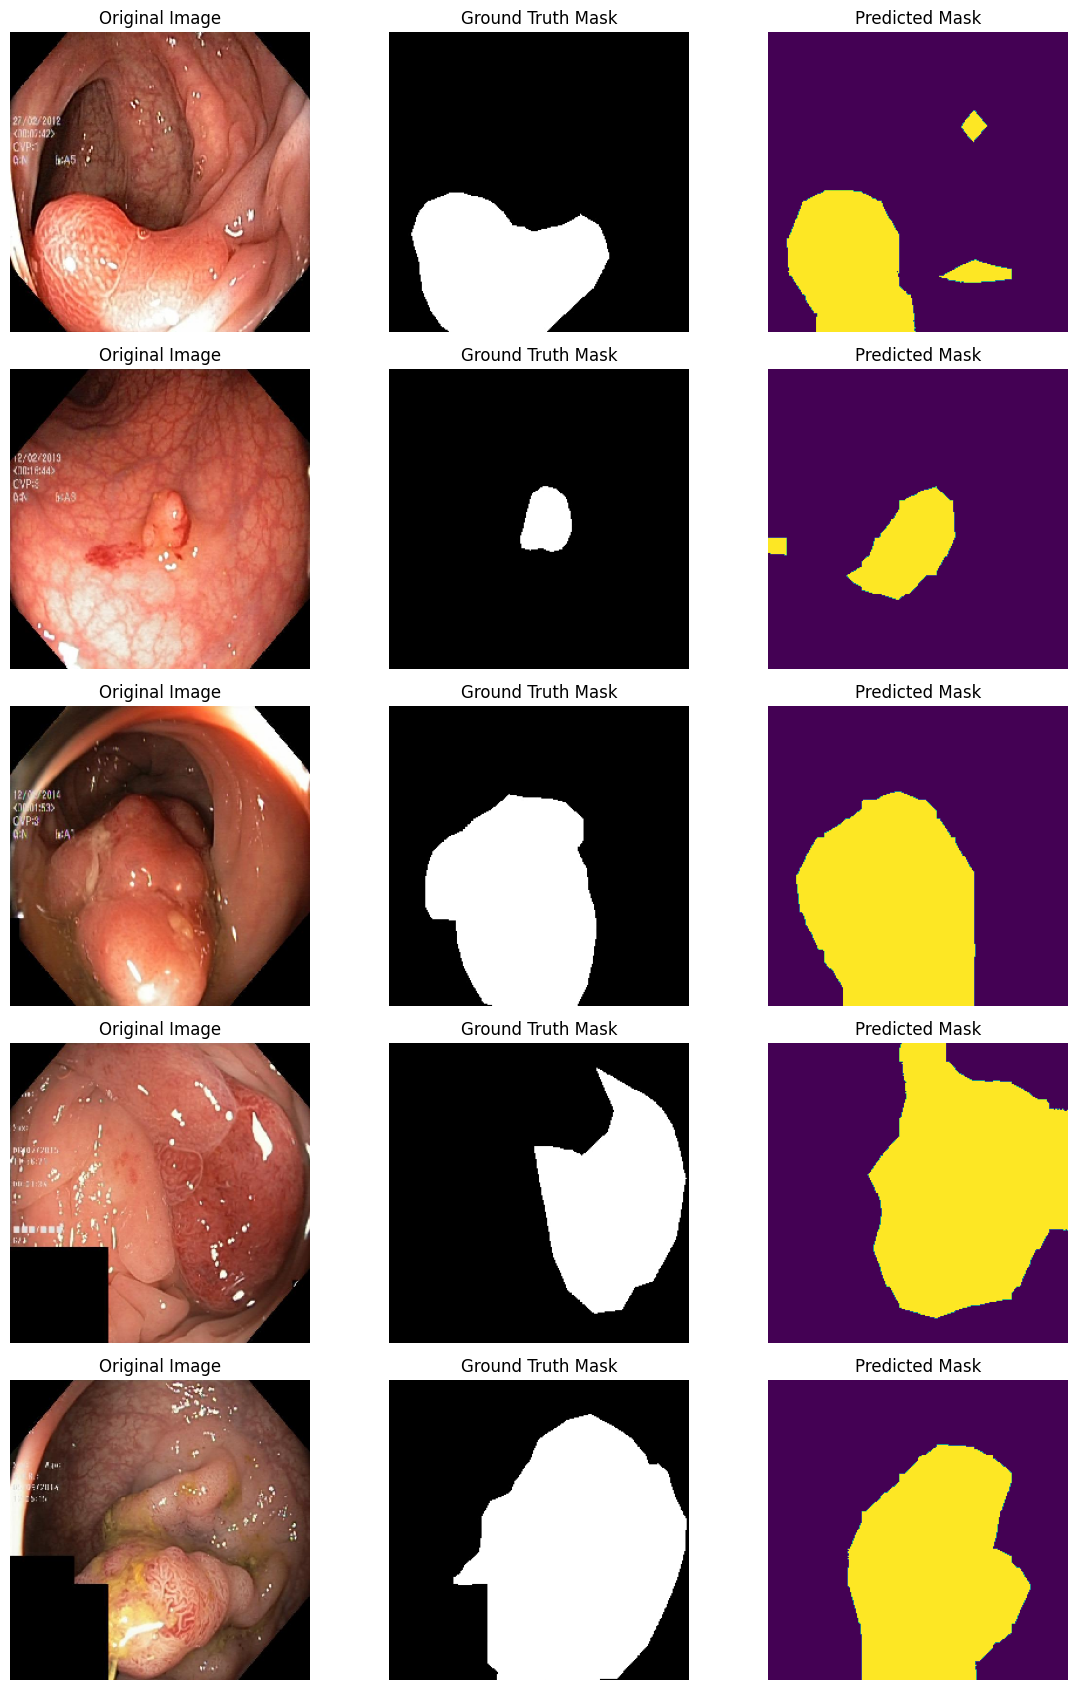

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Reset the generators
test_image_generator.reset()
test_mask_generator.reset()

# Get the corresponding test image and mask (from only 1 batch)
test_image = next(test_image_generator)
test_mask = next(test_mask_generator)

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_image)), 5)

# Generate predictions for the test image
prediction = loaded_fcn32.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_image[random_index])  # test_image is a batch, we extract the first image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_mask[random_index], cmap='gray')  # test_mask is a batch, we extract the first mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_prediction[random_index], cmap='viridis')  # binary_prediction is a batch, we extract the first prediction
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


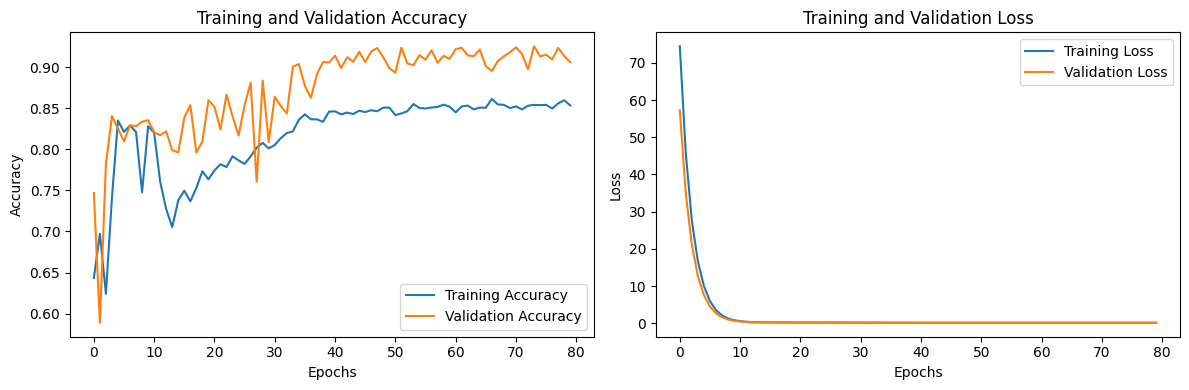

In [ ]:
history_fcn32 = history
train_accuracy = history_fcn32.history['accuracy']
val_accuracy = history_fcn32.history['val_accuracy']
train_loss = history_fcn32.history['loss']
val_loss = history_fcn32.history['val_loss']

# Plot the learning curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### PEFNet

In [ ]:
def ConvnextSmall(im_size):

    backbone = convnext.ConvNeXtSmall(input_shape=(im_size, im_size, 3), num_classes=0,
                                pretrained='imagenet21k-ft1k')

    layer_names = ['stack4_block3_output',
                  'stack3_block9_output',
                  'stack2_block3_output',
                  'stack1_block3_output']

    return backbone, layer_names

def EfficientNetV2B0(im_size):

    backbone = efficientnet.EfficientNetV2B0(input_shape=(im_size, im_size, 3), num_classes=0,
                                            pretrained='imagenet21k', include_preprocessing=True)

    layer_names = ['post_swish',
                    'stack_4_block4_output',
                    'stack_2_block1_output',
                    'stack_1_block1_output',
                    'stack_0_block0_output']

    return backbone, layer_names

In [ ]:
def bn_act(inputs, activation='swish'):

    x = BatchNormalization()(inputs)
    if activation:
        x = Activation(activation)(x)

    return x

def conv_bn_act(inputs, filters, kernel_size, strides=(1, 1), activation='swish', padding='same'):

    x = Conv2D(filters, kernel_size=kernel_size, padding=padding)(inputs)
    x = bn_act(x, activation=activation)

    return x

def decode(inputs, filters, activation='swish', padding='same'):

    x = Conv2DTranspose(filters, kernel_size=(4, 4), strides=(2, 2), padding=padding)(inputs)
    x = bn_act(x, activation=activation)

    return x

def block(inputs, filters):

    x1 = conv_bn_act(inputs, filters, 1)
    x2 = conv_bn_act(inputs, filters, 3)
    x3 = conv_bn_act(inputs, filters, 5)

    return x1 + x2 + x3

def merge(l, filters=None):
    if filters is None:
        channel_axis = 1 if K.image_data_format() == "channels_first" else -1
        filters = l[0].shape[channel_axis]

    x = tf.keras.layers.Add()(l)
    x = block(x, filters)

    return x

def conv_pos_emb(inputs, filters):

    x = block(inputs, filters)
    pos_emb = attention_layers.PositionalEmbedding()
    emb = pos_emb(x)

    return emb


In [ ]:
def PEFNet(img_size, num_classes = 1, backbone = 'efficientnetv2b0'):

    if backbone == 'efficientnetv2-b0':

        backbone, layer_names = EfficientNetV2B0(img_size)

    else:

        backbone, layer_names = ConvnextSmall(img_size)

    layers = [backbone.get_layer(x).output for x in layer_names]

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    h_axis, w_axis = [2, 3] if K.image_data_format() == "channels_first" else [1, 2]

    x = layers[0]

    for i, layer in enumerate(layers[1:]):
        x = decode(x, layer.shape[channel_axis])
        x = merge([x, layer], layer.shape[channel_axis])
        x = conv_pos_emb(x, layer.shape[channel_axis])

    filters = x.shape[channel_axis] // 2

    x = decode(x, filters)
    x = conv_pos_emb(x, filters)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(num_classes, kernel_size=1, padding='same', activation='sigmoid')(x)

    model = Model(backbone.input, x)

    return model

In [ ]:
PEFNet_model = PEFNet(256, backbone = 'convnext')
PEFNet_model.summary()

201821832/201821832 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/convnext_small_224_imagenet21k-ft1k.h5
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 64, 96)           4704      ['input_10[0][0]']            
                                                                                                  
 stem_ln (LayerNormalizatio  (None, 64, 64, 96)           192       ['stem_conv[0][0]']           
 n)                                                                                               
                                     

In [ ]:
font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 150)
# Visualize the model with the modified font size
visualkeras.layered_view(PEFNet_model, to_file='PEFNet_model.png', legend=True, font=font,
                         type_ignore=[Activation, LayerNormalization,BatchNormalization, Dropout,
                                      ZeroPadding2D, Dense, Conv2D]).show()

In [ ]:
# Compile the model
optimizer = Adam(learning_rate = 0.001, weight_decay=1e-4)
PEFNet_model.compile(optimizer=optimizer, loss = weighted_bincrossentropy,
                     metrics=['accuracy', dice_coefficient, dice_loss, iou_coefficient, iou_loss])

In [ ]:
steps_per_epoch = 800//32
validation_steps = 100//32
checkpoint_path = '/content/drive/MyDrive/Project-Deep-Learning/PEFNet.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_iou_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)

# Fit the model using the data generators
start = time.time()
history = PEFNet_model.fit(train_generator,
                          steps_per_epoch=steps_per_epoch,
                          epochs=80,
                          validation_data=val_generator,
                          validation_steps=validation_steps,
                          callbacks=[model_checkpoint, early_stopping, reduce_lr],
                          batch_size=32)
end = time.time()
print('Computational time: ', end-start, 's')

Epoch 1/80
25/25 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.8614 - dice_coefficient: 0.6507 - dice_loss: 0.3493 - iou_coefficient: 0.4839 - iou_loss: 0.5161
Epoch 1: val_iou_loss improved from inf to 0.36678, saving model to /content/drive/MyDrive/Project-Deep-Learning/PEFNet.h5
25/25 [==============================] - 120s 2s/step - loss: 0.0889 - accuracy: 0.8614 - dice_coefficient: 0.6507 - dice_loss: 0.3493 - iou_coefficient: 0.4839 - iou_loss: 0.5161 - val_loss: 0.0874 - val_accuracy: 0.9371 - val_dice_coefficient: 0.7752 - val_dice_loss: 0.2248 - val_iou_coefficient: 0.6332 - val_iou_loss: 0.3668 - lr: 0.0010
Epoch 2/80
25/25 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.8559 - dice_coefficient: 0.6339 - dice_loss: 0.3661 - iou_coefficient: 0.4675 - iou_loss: 0.5325
Epoch 2: val_iou_loss improved from 0.36678 to 0.33224, saving model to /content/drive/MyDrive/Project-Deep-Learning/PEFNet.h5
25/25 [============================

In [ ]:
custom_objects = {'weighted_bincrossentropy': weighted_bincrossentropy, 'dice_coefficient': dice_coefficient, 'dice_loss': dice_loss, 'iou_coefficient': iou_coefficient, 'iou_loss': iou_loss}
loaded_pefnet = tf.keras.models.load_model('/content/drive/MyDrive/Project-Deep-Learning/PEFNet.h5', custom_objects = custom_objects)

1/1 [==============================] - 0s 80ms/step
Random indices: [3, 17, 5, 26, 6]


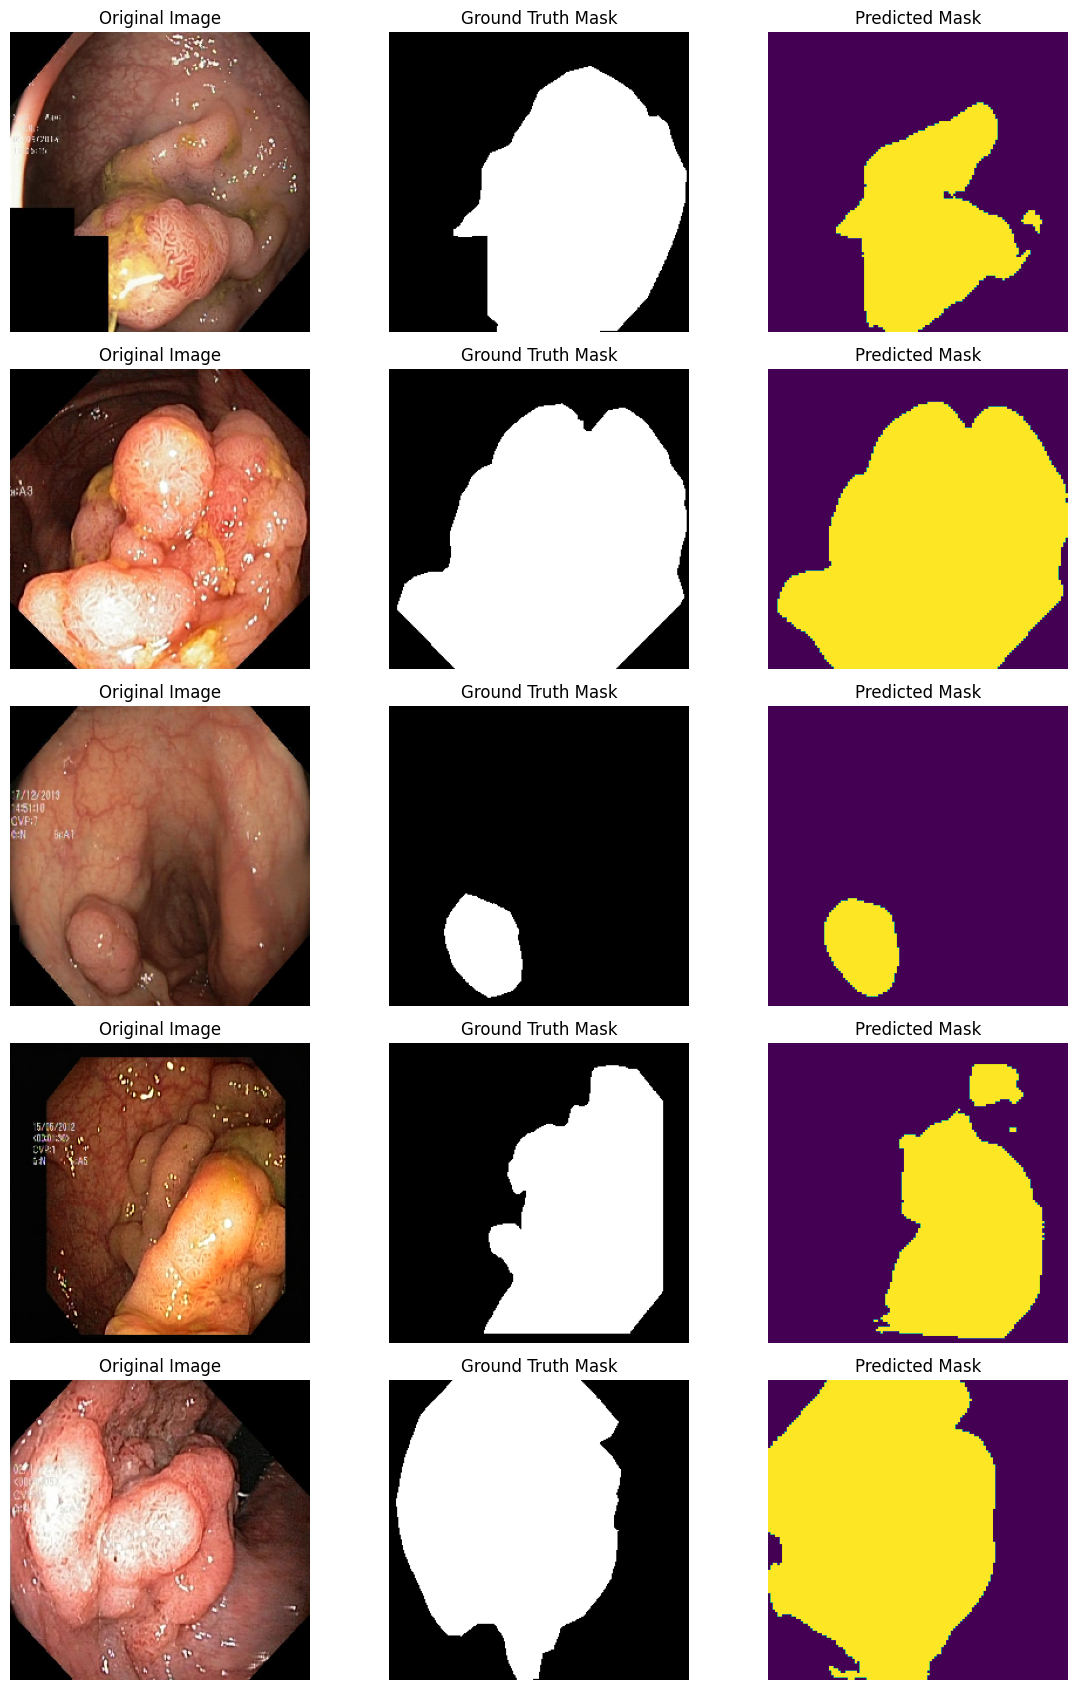

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Reset the generators
test_image_generator.reset()
test_mask_generator.reset()

# Get the corresponding test image and mask (from only 1 batch)
test_image = next(test_image_generator)
test_mask = next(test_mask_generator)

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_image)), 5)

# Generate predictions for the test image
prediction = loaded_pefnet.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_image[random_index])  # test_image is a batch, we extract the first image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_mask[random_index], cmap='gray')  # test_mask is a batch, we extract the first mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_prediction[random_index], cmap='viridis')  # binary_prediction is a batch, we extract the first prediction
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


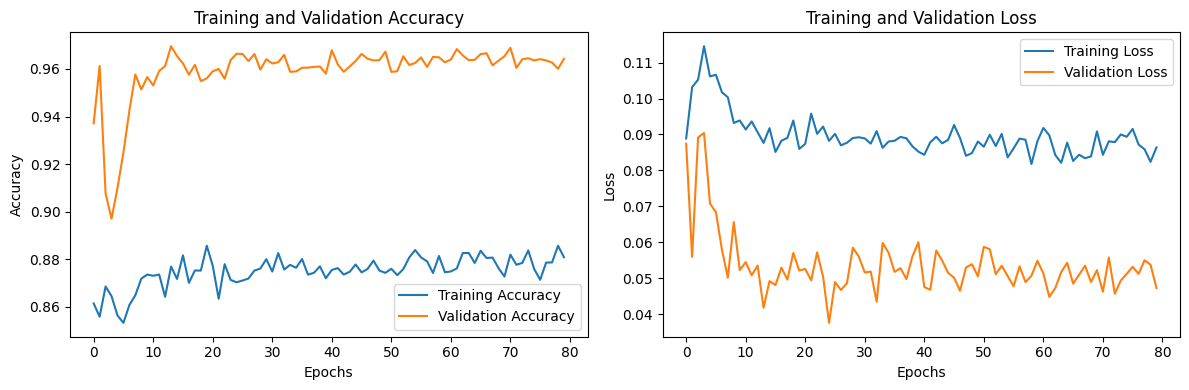

In [ ]:
history_pefnet = history
train_accuracy = history_pefnet.history['accuracy']
val_accuracy = history_pefnet.history['val_accuracy']
train_loss = history_pefnet.history['loss']
val_loss = history_pefnet.history['val_loss']

# Plot the learning curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

### DeepLabv3+

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
    activation="relu"
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1, activation='leakyrelu')
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6, activation='leakyrelu')
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12, activation='leakyrelu')
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18, activation='leakyrelu')

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1, activation = "sigmoid")
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same",activation='sigmoid')(x)
    return keras.Model(inputs=model_input, outputs=model_output)


DeepLabV3Plus_model = DeeplabV3Plus(image_size=256, num_classes=1)
DeepLabV3Plus_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_11[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
DeepLabV3Plus_model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001),
                            loss=weighted_bincrossentropy,
                            metrics=["accuracy", dice_coefficient, dice_loss, iou_coefficient, iou_loss])

In [ ]:
font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 100)
# Visualize the model with the modified font size
visualkeras.layered_view(DeepLabV3Plus_model, to_file='DeepLabv3_Plusmodel.png', legend=True, font=font, type_ignore=[BatchNormalization,ZeroPadding2D, Conv2D, Dropout]).show()

In [ ]:
steps_per_epoch = 800//32
validation_steps = 100//32
checkpoint_path = '/content/drive/MyDrive/Project-Deep-Learning/DeepLabV3Plus.h5'
# Callbacks
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_iou_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-6)

# Fit the model using the data generators
start = time.time()
history = DeepLabV3Plus_model.fit(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=80,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  callbacks=[model_checkpoint, early_stopping, reduce_lr],
                                  batch_size = 32)
end = time.time()
print('Computational time: ', end-start, 's')

Epoch 1/80
25/25 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.8646 - dice_coefficient: 0.6439 - dice_loss: 0.3561 - iou_coefficient: 0.4804 - iou_loss: 0.5196
Epoch 1: val_iou_loss improved from inf to 0.77955, saving model to /content/drive/MyDrive/Project-Deep-Learning/DeepLabV3Plus.h5
25/25 [==============================] - 26s 1s/step - loss: 0.0931 - accuracy: 0.8646 - dice_coefficient: 0.6439 - dice_loss: 0.3561 - iou_coefficient: 0.4804 - iou_loss: 0.5196 - val_loss: 0.2981 - val_accuracy: 0.8776 - val_dice_coefficient: 0.3599 - val_dice_loss: 0.6401 - val_iou_coefficient: 0.2205 - val_iou_loss: 0.7795 - lr: 1.0000e-04
Epoch 2/80
25/25 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.8639 - dice_coefficient: 0.6529 - dice_loss: 0.3471 - iou_coefficient: 0.4901 - iou_loss: 0.5099
Epoch 2: val_iou_loss did not improve from 0.77955
25/25 [==============================] - 21s 841ms/step - loss: 0.0898 - accuracy: 0.8639 - dice_coef

In [ ]:
custom_objects = {'weighted_bincrossentropy': weighted_bincrossentropy, 'dice_coefficient': dice_coefficient, 'dice_loss': dice_loss, 'iou_coefficient': iou_coefficient, 'iou_loss': iou_loss}
loaded_DeepLabV3Plus = tf.keras.models.load_model('/content/drive/MyDrive/Project-Deep-Learning/DeepLabV3Plus.h5', custom_objects = custom_objects)

1/1 [==============================] - 0s 35ms/step
Random indices: [3, 17, 5, 26, 6]


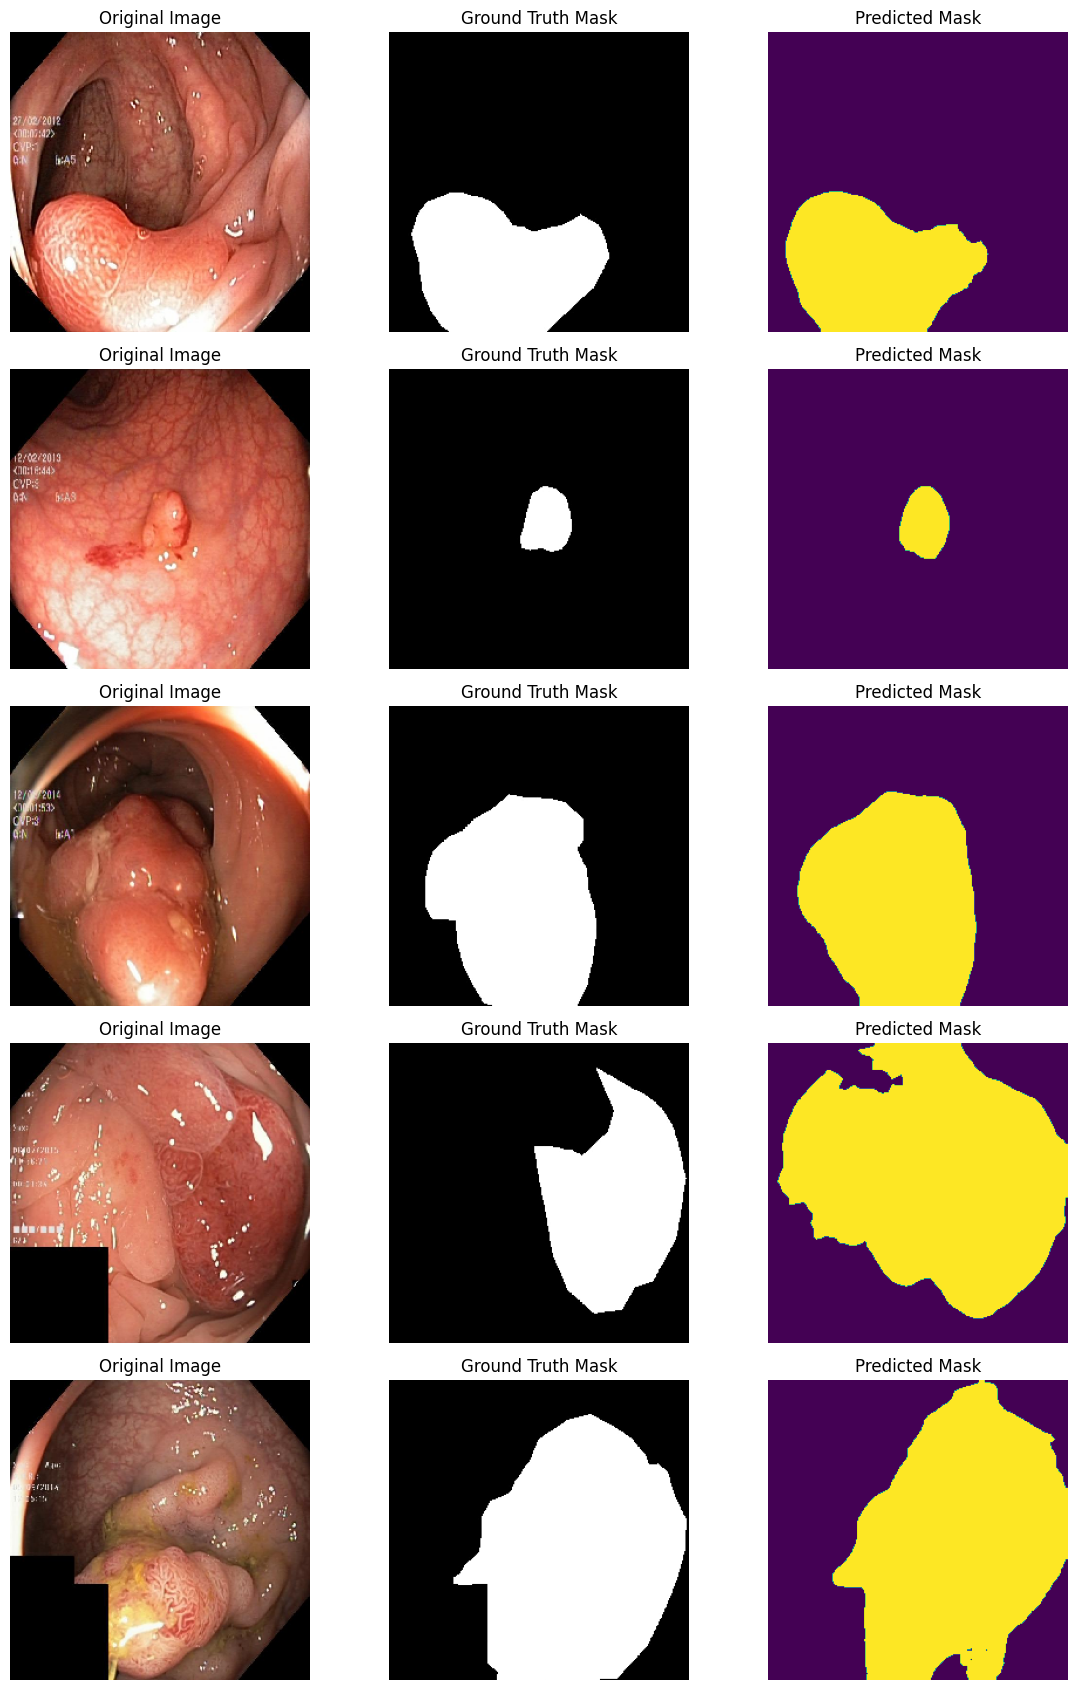

In [ ]:
# Fix the seed for reproducibility
random.seed(123)

# Reset the generators
test_image_generator.reset()
test_mask_generator.reset()

# Get the corresponding test image and mask (from only 1 batch)
test_image = next(test_image_generator)
test_mask = next(test_mask_generator)

# Get a random index to select 5 samples from the test batch
random_indices = random.sample(range(len(test_image)), 5)

# Generate predictions for the test image
prediction = loaded_DeepLabV3Plus.predict(test_image)

# Threshold the prediction to obtain the binary mask
binary_prediction = (prediction > 0.5).astype(np.uint8)

# Print random indices
print(f"Random indices: {random_indices}")

# Initialize subplots
plt.figure(figsize=(12, 17))

for i, random_index in enumerate(random_indices):
    # Plot the image, ground truth mask, and predicted mask side by side
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(test_image[random_index])  # test_image is a batch, we extract the first image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(test_mask[random_index], cmap='gray')  # test_mask is a batch, we extract the first mask
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(binary_prediction[random_index], cmap='viridis')  # binary_prediction is a batch, we extract the first prediction
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


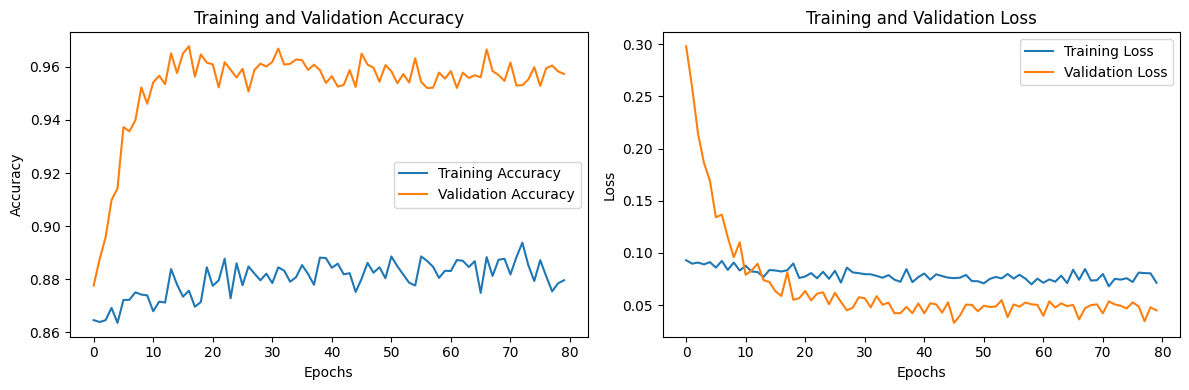

In [ ]:
history_DeepLabV3Plus = history
train_accuracy = history_DeepLabV3Plus.history['accuracy']
val_accuracy = history_DeepLabV3Plus.history['val_accuracy']
train_loss = history_DeepLabV3Plus.history['loss']
val_loss = history_DeepLabV3Plus.history['val_loss']

# Plot the learning curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluating Test Set

In [ ]:
def calculate_accuracy(predicted_mask, ground_truth_mask):
    total_pixels = predicted_mask.size
    correct_pixels = np.sum(predicted_mask == ground_truth_mask)
    accuracy = correct_pixels / total_pixels
    return accuracy

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def iou_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou


In [ ]:
def calculate_metrics(model, test_image_generator, test_mask_generator):
    iou_scores = []
    dice_scores = []
    accuracy_scores = []

    # Reset generators to maintain sequence
    test_image_generator.reset()
    test_mask_generator.reset()

    for i in range(len(test_mask_generator)):
        batch_images = next(test_image_generator)
        batch_masks = next(test_mask_generator)

        batch_predictions = model.predict(batch_images, verbose=0)
        binary_predictions = (batch_predictions > 0.5).astype(np.uint8)

        # Assuming you have functions for IoU, Dice, and accuracy calculations
        iou = iou_coef(binary_predictions, batch_masks)
        dice = dice_coef(binary_predictions, batch_masks)
        accuracy = calculate_accuracy(binary_predictions, batch_masks)

        iou_scores.append(iou)
        dice_scores.append(dice)
        accuracy_scores.append(accuracy)

    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    mean_accuracy = np.mean(accuracy_scores)

    return mean_iou, mean_dice, mean_accuracy


### FCN8

In [ ]:
# Usage example:
mean_iou_fcn8, mean_dice_fcn8, mean_accuracy_fcn8 = calculate_metrics(loaded_fcn8s, test_image_generator, test_mask_generator)
print(f"Mean IoU FCN8: {mean_iou_fcn8}")
print(f"Mean Dice Coefficient FCN8: {mean_dice_fcn8}")
print(f"Mean Accuracy FCN8: {mean_accuracy_fcn8}")

Mean IoU FCN8: 0.4123446047306061
Mean Dice Coefficient FCN8: 0.5813370943069458
Mean Accuracy FCN8: 0.8345718383789062


In [ ]:
start = time.time()
loaded_fcn8s.predict(test_image_generator)
end = time.time()
print('Segmentation Time: ', end - start, 's')

4/4 [==============================] - 1s 309ms/step
Segmentation Time:  1.6111564636230469 s


### FCN16

In [ ]:
# Usage example:
mean_iou_fcn16, mean_dice_fcn16, mean_accuracy_fcn16 = calculate_metrics(loaded_fcn16s, test_image_generator, test_mask_generator)
print(f"Mean IoU FCN16: {mean_iou_fcn16}")
print(f"Mean Dice Coefficient FCN16: {mean_dice_fcn16}")
print(f"Mean Accuracy FCN16: {mean_accuracy_fcn16}")

Mean IoU FCN16: 0.4300471842288971
Mean Dice Coefficient FCN16: 0.5995694398880005
Mean Accuracy FCN16: 0.8460202217102051


In [ ]:
start = time.time()
loaded_fcn16s.predict(test_image_generator)
end = time.time()
print('Segmentation Time: ', end - start, 's')

4/4 [==============================] - 1s 310ms/step
Segmentation Time:  1.5786545276641846 s


### FCN32

In [ ]:
# Usage example:
mean_iou_fcn32, mean_dice_fcn32, mean_accuracy_fcn32 = calculate_metrics(loaded_fcn32, test_image_generator, test_mask_generator)
print(f"Mean IoU FCN32: {mean_iou_fcn32}")
print(f"Mean Dice Coefficient FCN32: {mean_dice_fcn32}")
print(f"Mean Accuracy FCN32: {mean_accuracy_fcn32}")

Mean IoU FCN32: 0.6436337232589722
Mean Dice Coefficient FCN32: 0.7817108035087585
Mean Accuracy FCN32: 0.9205930233001709


In [ ]:
start = time.time()
loaded_fcn32.predict(test_image_generator)
end = time.time()
print('Segmentation Time: ', end - start, 's')

4/4 [==============================] - 1s 284ms/step
Segmentation Time:  1.286552906036377 s


### PEFNet

In [ ]:
# Usage example:
mean_iou_pefnet, mean_dice_pefnet, mean_accuracy_pefnet = calculate_metrics(loaded_pefnet, test_image_generator, test_mask_generator)
print(f"Mean IoU PEFNet: {mean_iou_pefnet}")
print(f"Mean Dice Coefficient PEFNet: {mean_dice_pefnet}")
print(f"Mean Accuracy PEFNet: {mean_accuracy_pefnet}")

Mean IoU PEFNet: 0.8169585466384888
Mean Dice Coefficient PEFNet: 0.8971327543258667
Mean Accuracy PEFNet: 0.96074378490448


In [ ]:
start = time.time()
loaded_pefnet.predict(test_image_generator)
end = time.time()
print('Segmentation Time: ', end - start, 's')

4/4 [==============================] - 5s 125ms/step
Segmentation Time:  4.940644264221191 s


### DeepLabV3+

In [ ]:
# Usage example:
mean_iou_deeplabv3_plus, mean_dice_deeplabv3_plus, mean_accuracy_deeplabv3_plus = calculate_metrics(loaded_DeepLabV3Plus, test_image_generator, test_mask_generator)
print(f"Mean IoU DeepLabV3+: {mean_iou_deeplabv3_plus}")
print(f"Mean Dice DeepLabV3+: {mean_dice_deeplabv3_plus}")
print(f"Mean Accuracy DeepLabV3+: {mean_accuracy_deeplabv3_plus}")

Mean IoU DeepLabV3+: 0.7417301535606384
Mean Dice DeepLabV3+: 0.8489598035812378
Mean Accuracy DeepLabV3+: 0.9443135261535645


In [ ]:
start = time.time()
loaded_DeepLabV3Plus.predict(test_image_generator)
end = time.time()
print('Segmentation Time: ', end - start, 's')

4/4 [==============================] - 2s 222ms/step
Segmentation Time:  2.091001510620117 s


## Prediction by Five Models

1/1 [==============================] - 0s 214ms/step


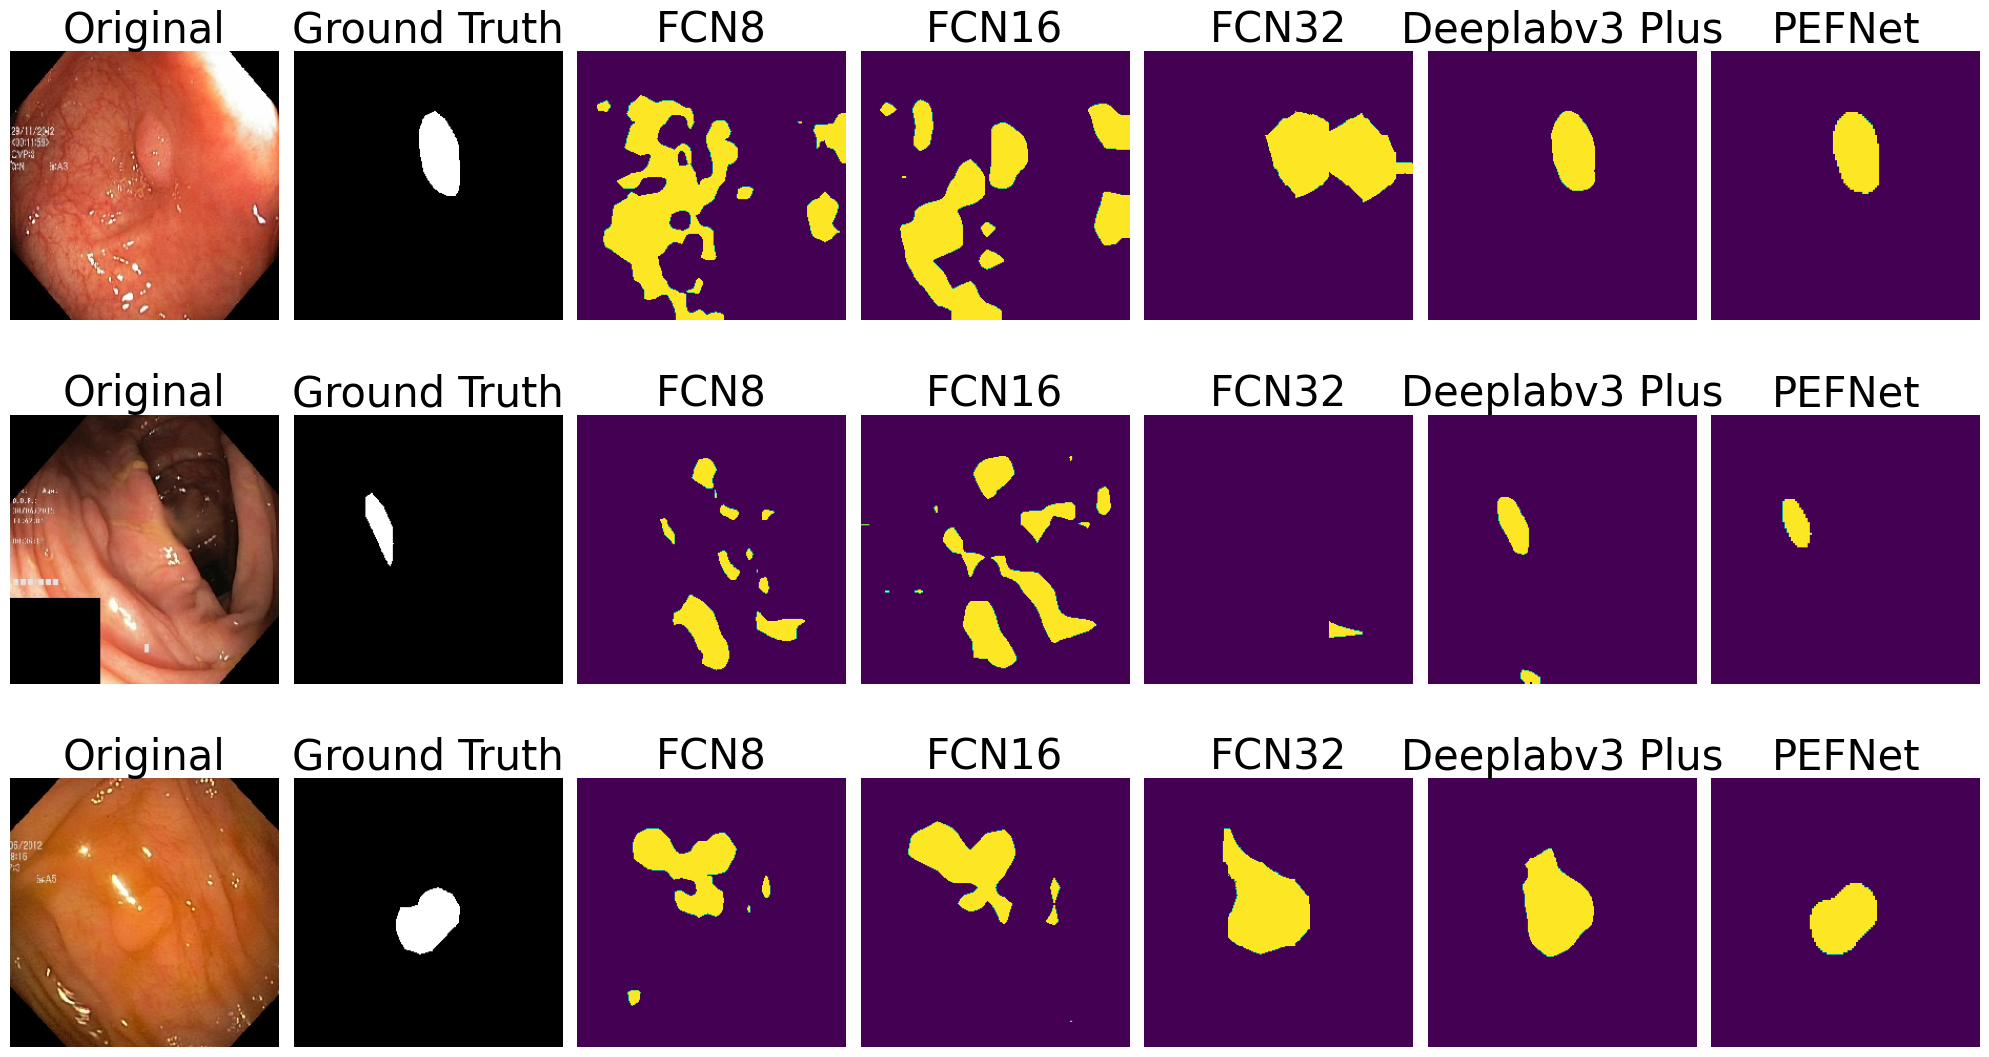

In [ ]:
# Assuming you have 5 loaded models stored in variables as described:
# loaded_fcn16s, loaded_fcn8s, loaded_fcn32, loaded_DeepLabV3Plus, loaded_pefnet

# Fix the seed for reproducibility
random.seed(123)

# Reset the generators
test_image_generator.reset()
test_mask_generator.reset()

# Get the corresponding test image and mask (from only 1 batch)
test_image = next(test_image_generator)
test_mask = next(test_mask_generator)

# Get a random index to select 3 samples from the test batch
random_indices = random.sample(range(len(test_image)), 3)

# Initialize subplots
plt.figure(figsize=(20, 15))

for i, random_index in enumerate(random_indices):
    # Plot the original image and ground truth mask
    plt.subplot(4, 7, i*7 + 1)
    plt.imshow(test_image[random_index])  # test_image is a batch, we extract the first image
    plt.title('Original', fontsize=30)
    plt.axis('off')

    plt.subplot(4, 7, i*7 + 2)
    plt.imshow(test_mask[random_index], cmap='gray')  # test_mask is a batch, we extract the first mask
    plt.title('Ground Truth', fontsize = 30)
    plt.axis('off')

    # Dictionary mapping loaded models to their names
    loaded_models = {
        loaded_fcn8s: 'FCN8',
        loaded_fcn16s: 'FCN16',
        loaded_fcn32: 'FCN32',
        loaded_DeepLabV3Plus: 'Deeplabv3 Plus',
        loaded_pefnet: 'PEFNet'
    }

    # Iterate through each loaded model to make predictions
    for j, (loaded_model, model_name) in enumerate(loaded_models.items()):
        # Generate predictions for the test image using each model
        prediction = loaded_model.predict(test_image)
        # Threshold the prediction to obtain the binary mask
        binary_prediction = (prediction > 0.5).astype(np.uint8)

        # Plot the predicted mask for each model
        plt.subplot(4, 7, i*7 + 3 + j)
        plt.imshow(binary_prediction[random_index], cmap='viridis')  # binary_prediction is a batch, we extract the first prediction
        plt.title(f'{model_name}', fontsize=30)
        plt.axis('off')

plt.tight_layout()
plt.show()